In [608]:
%load_ext autoreload
%autoreload 2

from doc2vec.util.Logger import Logger
from doc2vec.preprocessor.preprocessing import *
from soyspacing.countbase import CountSpace
from soynlp.normalizer import *
from doc2vec.util.common import set_pandas_format, set_matplotlib_sns_font, save_pickle, load_pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import rootpath
import os
import time
import multiprocessing
from doc2vec.preprocessor.multiprocess import *
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime, timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:
set_pandas_format() 
set_matplotlib_sns_font()
logger = Logger(file_name=__name__).logger

# 데이터 로드

- doc2vec을 진행하면서 정제된 데이터를 사용함

In [808]:
final_news_df = load_pickle(os.path.join(rootpath.detect(), *["data", "rec", "final_news_df.pickle"]))

In [815]:
final_news_df.reset_index(drop=True, inplace=True)

In [816]:
final_news_df.tail()

,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents,article_title2,clean_article_contents,clean_article_contents_len,article_contents2,tagged_doc,doc_remove_pos
39314,NB12040863,80,날씨,202112300744,2021-12-30 07:44:05.710,출근길 다시 찾아온 한파…충남·전라권 등 눈비 소식,"<div class=""jtbc_img"" id=""txtTag550_...","[출근길/NNG, 한파/NNG, 충남/NNP, 전라/NNG, 눈비/NNG, 소식/NNG]",주춤했던 추위가 하루 만에 다시 찾아왔습니다. 오늘 은 충남과 전라권 제주도 등을 ...,724,"[추위/NNG, 하루/NNG, 충남/NNP, 전라/NNG, 제주도/NNP, 제외/N...","[출근길/NNG, 한파/NNG, 충남/NNP, 전라/NNG, 눈비/NNG, 소식/N...","[출근길, 한파, 충남, 전라, 눈비, 소식, 추위, 하루, 충남, 전라, 제주도,..."
39315,NB12040963,80,날씨,202112302053,2021-12-30 18:54:31.617,[날씨] 강추위 이어져…'대설특보' 충남·전북 최대 8㎝ 눈,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[강추위/NNG, 대설/NNG, 특보/NNG, 충남/NNP, 전북/NNP, 최대/N...",올해 마지막 날인 내일 도 매우 춥겠습니다. 아침기온은 영하 15도에서 영하 1도 ...,116,"[올해/NNG, 마지막/NNG, 내일/NNG, 아침/NNG, 기온/NNG, 영하/N...","[강추위/NNG, 대설/NNG, 특보/NNG, 충남/NNP, 전북/NNP, 최대/N...","[강추위, 대설, 특보, 충남, 전북, 최대, 눈, 올해, 마지막, 내일, 아침, ..."
39316,NB12040972,80,날씨,202112310830,2021-12-31 06:18:27.737,[날씨] 올해 마지막날 강추위 기승…울릉도·전라·제주 눈,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[올해/NNG, 마지막/NNG, 강추위/NNG, 기승/NNG, 울릉도/NNP, 전라...",오늘 아침 중부 지방의 기온이 영하 10도 안팎까지 떨어지면서 세밑한파가 기승입니다...,181,"[아침/NNG, 중부/NNG, 지방/NNG, 기온/NNG, 영하/NNG, 안팎/NN...","[올해/NNG, 마지막/NNG, 강추위/NNG, 기승/NNG, 울릉도/NNP, 전라...","[올해, 마지막, 강추위, 기승, 울릉도, 전라, 제주, 눈, 아침, 중부, 지방,..."
39317,NB12040992,80,날씨,202112310718,2021-12-31 07:18:05.753,올해 마지막 날 '전국이 꽁꽁'…전라·제주 아침까지 눈,"<div class=""jtbc_img"" id=""txtTag550_...","[올해/NNG, 마지막/NNG, 전국/NNG, 전라/NNP, 제주/NNP, 아침/N...",올해 마지막 날인 오늘 도 옷차림에 단단히 신경 쓰셔야겠습니다. 전국 하늘은 대체로...,458,"[올해/NNG, 마지막/NNG, 오늘/NNG, 옷차림/NNG, 신경/NNG, 전국/...","[올해/NNG, 마지막/NNG, 전국/NNG, 전라/NNP, 제주/NNP, 아침/N...","[올해, 마지막, 전국, 전라, 제주, 아침, 눈, 올해, 마지막, 오늘, 옷차림,..."
39318,NB12041067,80,날씨,202112312101,2021-12-31 18:09:03.013,[날씨] 아침 최저기온 영하 16도…오후부터 한파 풀려,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[아침/NNG, 최저기온/NNP, 영하/NNG, 오후/NNG, 한파/NNG]",새해 첫날인 내일 오전에 춥다가 오후부터 조금씩 풀리겠습니다. 아침 기온은 영하 1...,129,"[새해/NNG, 첫날/NNG, 내일/NNG, 오전/NNG, 오후/NNG, 아침/NN...","[아침/NNG, 최저기온/NNP, 영하/NNG, 오후/NNG, 한파/NNG, 새해/...","[아침, 최저기온, 영하, 오후, 한파, 새해, 첫날, 내일, 오전, 오후, 아침,..."


In [191]:
final_news_df.head(4)

,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents,article_title2,clean_article_contents,clean_article_contents_len,article_contents2,tagged_doc,doc_remove_pos
0,NB11987509,0,종합,202101101609,2021-01-10 16:07:08.047,정인이 양부모 13일 첫 재판…살인죄 적용 가능성 주목,"<!-- @ckeditor_contents_s@ -->검찰, 사망원인 재감정 의뢰&...","[정인/NNG, 양부모/NNG, 재판/NNG, 살인죄/NNG, 적용/NNG, 가능/...",검찰 사망원인 재감정 의뢰 양부모 엄벌 진정서 쇄도 16개월 된 입양아 정인양을 수...,987,"[검찰/NNG, 망원/NNG, 감정/NNG, 의뢰/NNG, 양부모/NNG, 엄벌/N...","[정인/NNG, 양부모/NNG, 재판/NNG, 살인죄/NNG, 적용/NNG, 가능/...","[정인, 양부모, 재판, 살인죄, 적용, 가능, 주목, 검찰, 망원, 감정, 의뢰,..."
1,NB11992028,0,종합,202102111055,2021-02-11 10:55:29.993,2년만에 결론난 LG·SK 배터리 소송…특허침해 사건은 남아,<!-- @ckeditor_contents_s@ -->LG &quot;SK가 핵심인...,"[결론/NNG, lg/SL, sk/SL, 배터리/NNG, 소송/NNG, 특허/NNG...",lg sk가 핵심인력 76명 빼갔다 주장 국내외 합의 촉구에도 끝내 평행선 lg s...,2830,"[lg/SL, sk/SL, 핵심/NNG, 인력/NNG, 주장/NNG, 국내외/NNG...","[결론/NNG, lg/SL, sk/SL, 배터리/NNG, 소송/NNG, 특허/NNG...","[결론, lg, sk, 배터리, 소송, 특허, 침해, 사건, lg, sk, 핵심, ..."
2,NB11992031,0,종합,202102111216,2021-02-11 12:16:04.310,"연휴 첫날 전국 역·터미널, 재래시장 한산…공항은 북적","<!-- @ckeditor_contents_s@ --><div class=""jtbc...","[연휴/NNG, 첫날/NNG, 전국/NNG, 역/NNG, 터미널/NNG, 재래/NN...",부산역 대합실 평소와 비슷한 인구이동 재래시장도 한적 제주공항 제주행 청주공항 골프...,1412,"[부산역/NNP, 대합실/NNG, 평소/NNG, 인구/NNG, 이동/NNP, 재래시...","[연휴/NNG, 첫날/NNG, 전국/NNG, 역/NNG, 터미널/NNG, 재래/NN...","[연휴, 첫날, 전국, 역, 터미널, 재래, 시장, 공항, 북적, 부산역, 대합실,..."
3,NB12021784,0,종합,202108291427,2021-08-29 14:27:06.750,"윤석열 첫 공약 발표…""청년에 '원가주택' 공급…LTV 80％로 인상""","<!-- @ckeditor_contents_s@ --><div class=""jtbc...","[윤석열/NNP, 공약/NNG, 발표/NNG, 청년/NNG, 원가/NNG, 주택/N...",국민의힘 대권주자인 윤석열 전 검찰총장은 29일 청년 원가 주택 과 역세권 첫집 주...,1060,"[국민의힘/NNP, 대권주자/NNP, 윤석열/NNP, 검찰/NNG, 총장/NNG, ...","[윤석열/NNP, 공약/NNG, 발표/NNG, 청년/NNG, 원가/NNG, 주택/N...","[윤석열, 공약, 발표, 청년, 원가, 주택, 공급, ltv, 인상, 국민의힘, 대..."


In [192]:
index = final_news_df[final_news_df.news_id=="NB12007718"].index
print(final_news_df.iloc[index].article_title)
print(clean_content(final_news_df.iloc[index].article_title.values[0]))


18721    도쿄조직위, '욱일기 응원' 공식화…"차별 행위 아니다"
Name: article_title, dtype: object
도쿄조직위 욱일기 응원 공식화 차별 행위 아니다


# token 생성
- title + content를 기준으로 생성 (title만 하기에는 전처리 과정에서 title이 제거 되기도 함)

In [817]:
# tokens = final_news_df.article_title2.values.tolist()
corpus = final_news_df.tagged_doc.values.tolist()

In [818]:
len(corpus)

39319

In [819]:
corpus[:10]

[['정인이/NNP',
  '양부모/NNG',
  '재판/NNG',
  '살인죄/NNG',
  '적용/NNG',
  '가능/NNG',
  '주목/NNG',
  '검찰/NNG',
  '망원/NNG',
  '감정/NNG',
  '의뢰/NNG',
  '양부모/NNG',
  '엄벌/NNG',
  '진정서/NNG',
  '쇄도/NNG',
  '입양아/NNG',
  '정인양/NNP',
  '수개월/NNG',
  '학대/NNG',
  '사망/NNG',
  '혐의/NNG',
  '양부모/NNG',
  '이번/NNG',
  '법정/NNG',
  '법원/NNG',
  '서울/NNP',
  '남부/NNG',
  '지법/NNG',
  '형사/NNG',
  '아동학대/NNP',
  '처벌/NNG',
  '법/NNG',
  '위반/NNG',
  '혐의/NNG',
  '구속/NNG',
  '기소/NNG',
  '양모/NNG',
  '장모/NNG',
  '아동/NNG',
  '복지/NNG',
  '법/NNG',
  '위반/NNG',
  '혐의/NNG',
  '양부/NNG',
  '안모/NNG',
  '공판/NNG',
  '장/NNP',
  '지난해/NNG',
  '입양/NNG',
  '딸/NNG',
  '정인양/NNP',
  '상습/NNG',
  '폭행/NNG',
  '학대/NNG',
  '부위/NNG',
  '충격/NNG',
  '혐의/NNG',
  '재판/NNG',
  '지난해/NNG',
  '차례/NNG',
  '정인양/NNP',
  '자동차/NNG',
  '방치/NNG',
  '유모차/NNG',
  '엘리베이터/NNG',
  '벽/NNG',
  '정서/NNG',
  '학대/NNG',
  '혐의/NNG',
  '장/NNP',
  '학대/NNG',
  '사실/NNG',
  '악화/NNG',
  '정인/NNG',
  '양/NNG',
  '건강/NNG',
  '상태/NNG',
  '인지/NNG',
  '조처/NNG',
  '남편/NNG',
  '구속/NNG',
  '상태/NNG',
  '

# Word2Vec 모델 생성 및 저장

## 미리 만들어진 word2vec 가져오기

아래 사이트에서 korean(W)가 word2vec 모델임
- https://github.com/Kyubyong/wordvectors


In [104]:
# 버전 이슈로 내부 gensim 다운그레이 하지 않으면 쓸 수가 없음. 
# public word2vec 버전: 3.8.3
# 내부 gensim 버전: 4.1.3
# model_path = os.path.join(rootpath.detect(), *['model', 'ko.bin'])

# model = gensim.models.word2vec.Word2Vec.load(model_path)



## 모델 생성

In [355]:
import gensim
import multiprocessing
# 아래 FAST_VERSION을 쓰면, 자체적으로 c complier를 사용하여 학습 시킴
from gensim.models.word2vec import FAST_VERSION
def build_model() -> gensim.models.word2vec.Word2Vec:
	# using all available CPU cores.
	cores = multiprocessing.cpu_count()

# 	model = gensim.models.word2vec.Word2Vec(sentences=tokens, vector_size=1000, min_count=6, epochs=100,
#                                             workers=cores, window=5, sg=1)
	model = gensim.models.word2vec.Word2Vec(vector_size=1000, min_count=6,
                                            workers=cores, window=5, sg=1)

	print(type(model))

	return model

In [820]:
model = build_model()

print(dir(model))
print(model.corpus_count) # 현재 학습된 corpus가 없음을 확인함
print(model.epochs) # 기본 Epochs는 5

2022-05-09 18:00:56,359 [INFO] - utils.py:add_lifecycle_event - line:447 - Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=1000, alpha=0.025)', 'datetime': '2022-05-09T18:00:56.353065', 'gensim': '4.1.2', 'python': '3.9.10 (main, Jan 15 2022, 11:48:00) \n[Clang 13.0.0 (clang-1300.0.29.3)]', 'platform': 'macOS-12.2.1-x86_64-i386-64bit', 'event': 'created'}


<class 'gensim.models.word2vec.Word2Vec'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_adapt_by_suffix', '_check_corpus_sanity', '_check_training_sanity', '_clear_post_train', '_do_train_epoch', '_do_train_job', '_get_next_alpha', '_get_thread_working_mem', '_job_producer', '_load_specials', '_log_epoch_end', '_log_epoch_progress', '_log_progress', '_log_train_end', '_raw_word_count', '_save_specials', '_scan_vocab', '_smart_save', '_train_epoch', '_train_epoch_corpusfile', '_worker_loop', '_worker_loop_corpusfile', 'add_lifecycle_event', 'add_null_word', 'alpha', 'batch_words', 'build_vocab', 'build_vocab_from_freq', 'cbow_mean', 'comment', 'compute_loss', 'corpus_count',

In [821]:
model.build_vocab(corpus)
model.train(corpus, total_examples=model.corpus_count, epochs=100)

2022-05-09 18:01:01,025 [INFO] - word2vec.py:scan_vocab - line:578 - collecting all words and their counts
2022-05-09 18:01:01,027 [INFO] - word2vec.py:_scan_vocab - line:561 - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-05-09 18:01:01,283 [INFO] - word2vec.py:_scan_vocab - line:561 - PROGRESS: at sentence #10000, processed 1453195 words, keeping 37379 word types
2022-05-09 18:01:01,554 [INFO] - word2vec.py:_scan_vocab - line:561 - PROGRESS: at sentence #20000, processed 2919752 words, keeping 51286 word types
2022-05-09 18:01:01,861 [INFO] - word2vec.py:_scan_vocab - line:561 - PROGRESS: at sentence #30000, processed 4400902 words, keeping 59916 word types
2022-05-09 18:01:02,146 [INFO] - word2vec.py:scan_vocab - line:584 - collected 66395 word types from a corpus of 5746459 raw words and 39319 sentences
2022-05-09 18:01:02,150 [INFO] - word2vec.py:prepare_vocab - line:633 - Creating a fresh vocabulary
2022-05-09 18:01:02,291 [INFO] - utils.py:add_lifecycle_

2022-05-09 18:01:40,398 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 1 - PROGRESS: at 95.91% examples, 143890 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:01:41,138 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-09 18:01:41,220 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-09 18:01:41,234 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-09 18:01:41,313 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:01:41,363 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-09 18:01:41,369 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-09 18:01:41,38

2022-05-09 18:02:19,835 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-09 18:02:19,856 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-09 18:02:19,876 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-09 18:02:19,892 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-09 18:02:19,893 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:02:19,894 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 2 : training on 5746459 raw words (5607531 effective words) took 38.3s, 146397 effective words/s
2022-05-09 18:02:21,255 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 3 - PROGRESS: at 2.40% examples, 92279 words/s, in_qsize 

2022-05-09 18:03:00,214 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 4 - PROGRESS: at 9.09% examples, 129933 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:03:01,678 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 4 - PROGRESS: at 12.97% examples, 138198 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:03:02,736 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 4 - PROGRESS: at 16.01% examples, 145681 words/s, in_qsize 20, out_qsize 3
2022-05-09 18:03:03,891 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 4 - PROGRESS: at 18.74% examples, 143811 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:03:04,975 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 4 - PROGRESS: at 22.49% examples, 148213 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:03:06,113 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 4 - PROGRESS: at 25.09% examples, 146728 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:03:07,219 [INFO] - word2vec.py:_log_progress - line:1585 - EPOC

2022-05-09 18:03:47,841 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 5 - PROGRESS: at 41.55% examples, 157328 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:03:49,057 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 5 - PROGRESS: at 43.80% examples, 153795 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:03:50,112 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 5 - PROGRESS: at 47.53% examples, 156757 words/s, in_qsize 22, out_qsize 1
2022-05-09 18:03:51,659 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 5 - PROGRESS: at 49.89% examples, 150994 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:03:52,704 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 5 - PROGRESS: at 53.42% examples, 152788 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:03:54,130 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 5 - PROGRESS: at 56.12% examples, 149744 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:03:55,529 [INFO] - word2vec.py:_log_progress - line:1585 - EPO

2022-05-09 18:04:36,205 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 6 - PROGRESS: at 76.34% examples, 157570 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:04:37,213 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 6 - PROGRESS: at 79.01% examples, 157404 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:04:38,341 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 6 - PROGRESS: at 82.46% examples, 157933 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:04:39,348 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 6 - PROGRESS: at 85.26% examples, 157747 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:04:40,499 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 6 - PROGRESS: at 88.50% examples, 158104 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:04:41,645 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 6 - PROGRESS: at 91.55% examples, 157567 words/s, in_qsize 22, out_qsize 1
2022-05-09 18:04:42,730 [INFO] - word2vec.py:_log_progress - line:1585 - EPO

2022-05-09 18:05:18,692 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-09 18:05:18,767 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-09 18:05:18,841 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-09 18:05:18,848 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-09 18:05:18,876 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-09 18:05:18,882 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-09 18:05:18,884 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:05:18,884 [INFO] - word2vec

2022-05-09 18:05:57,019 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 9 - PROGRESS: at 9.09% examples, 144595 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:05:58,045 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 9 - PROGRESS: at 11.96% examples, 150653 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:05:59,130 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 9 - PROGRESS: at 14.74% examples, 152441 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:06:00,133 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 9 - PROGRESS: at 17.82% examples, 157266 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:06:01,193 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 9 - PROGRESS: at 20.66% examples, 156835 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:06:02,219 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 9 - PROGRESS: at 23.67% examples, 154984 words/s, in_qsize 22, out_qsize 1
2022-05-09 18:06:03,245 [INFO] - word2vec.py:_log_progress - line:1585 - EPOC

2022-05-09 18:06:43,097 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 10 - PROGRESS: at 43.80% examples, 159469 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:06:44,127 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 10 - PROGRESS: at 46.49% examples, 158888 words/s, in_qsize 24, out_qsize 1
2022-05-09 18:06:45,211 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 10 - PROGRESS: at 49.89% examples, 160111 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:06:46,211 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 10 - PROGRESS: at 52.73% examples, 159772 words/s, in_qsize 21, out_qsize 2
2022-05-09 18:06:47,255 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 10 - PROGRESS: at 56.17% examples, 161123 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:06:48,286 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 10 - PROGRESS: at 58.84% examples, 160117 words/s, in_qsize 22, out_qsize 1
2022-05-09 18:06:49,384 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:07:29,288 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 11 - PROGRESS: at 79.15% examples, 163294 words/s, in_qsize 23, out_qsize 1
2022-05-09 18:07:30,362 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 11 - PROGRESS: at 82.79% examples, 164248 words/s, in_qsize 24, out_qsize 1
2022-05-09 18:07:31,402 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 11 - PROGRESS: at 85.59% examples, 163666 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:07:32,448 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 11 - PROGRESS: at 88.76% examples, 164369 words/s, in_qsize 22, out_qsize 1
2022-05-09 18:07:33,487 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 11 - PROGRESS: at 91.76% examples, 163836 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:07:34,525 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 11 - PROGRESS: at 95.53% examples, 164808 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:07:35,471 [INFO] - word2vec.py:_log_epoch_progress - lin

2022-05-09 18:08:09,086 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-09 18:08:09,094 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-09 18:08:09,195 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-09 18:08:09,196 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-09 18:08:09,247 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-09 18:08:09,270 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-09 18:08:09,272 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:08:09,273 [INFO] - word2vec

2022-05-09 18:08:47,722 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 14 - PROGRESS: at 14.74% examples, 155719 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:08:49,044 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 14 - PROGRESS: at 18.74% examples, 159655 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:08:50,382 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 14 - PROGRESS: at 23.14% examples, 161942 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:08:51,384 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 14 - PROGRESS: at 26.48% examples, 165358 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:08:52,556 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 14 - PROGRESS: at 29.28% examples, 162460 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:08:53,700 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 14 - PROGRESS: at 33.09% examples, 165715 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:08:54,710 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:09:34,399 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 15 - PROGRESS: at 56.17% examples, 165743 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:09:35,452 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 15 - PROGRESS: at 59.66% examples, 166700 words/s, in_qsize 24, out_qsize 1
2022-05-09 18:09:36,475 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 15 - PROGRESS: at 62.40% examples, 166366 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:09:37,489 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 15 - PROGRESS: at 65.62% examples, 167016 words/s, in_qsize 24, out_qsize 1
2022-05-09 18:09:38,553 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 15 - PROGRESS: at 69.00% examples, 166880 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:09:39,586 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 15 - PROGRESS: at 72.38% examples, 168155 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:09:40,658 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:10:19,579 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 16 - PROGRESS: at 92.94% examples, 167981 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:10:20,588 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 16 - PROGRESS: at 96.07% examples, 168070 words/s, in_qsize 22, out_qsize 0
2022-05-09 18:10:21,215 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-09 18:10:21,247 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-09 18:10:21,249 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-09 18:10:21,281 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:10:21,313 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
202

2022-05-09 18:10:54,330 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 17 : training on 5746459 raw words (5607434 effective words) took 32.8s, 170933 effective words/s
2022-05-09 18:10:55,515 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 18 - PROGRESS: at 2.40% examples, 105453 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:10:56,949 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 18 - PROGRESS: at 6.93% examples, 136340 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:10:58,291 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 18 - PROGRESS: at 11.02% examples, 148774 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:10:59,300 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 18 - PROGRESS: at 14.56% examples, 163162 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:11:00,306 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 18 - PROGRESS: at 16.58% examples, 156676 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:11:01,342 [INFO] - word2vec.py:_l

2022-05-09 18:11:41,028 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 19 - PROGRESS: at 41.92% examples, 165455 words/s, in_qsize 21, out_qsize 2
2022-05-09 18:11:42,385 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 19 - PROGRESS: at 45.88% examples, 165956 words/s, in_qsize 22, out_qsize 1
2022-05-09 18:11:43,721 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 19 - PROGRESS: at 49.89% examples, 166570 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:11:45,039 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 19 - PROGRESS: at 53.92% examples, 167198 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:11:46,339 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 19 - PROGRESS: at 58.26% examples, 167978 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:11:47,648 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 19 - PROGRESS: at 62.27% examples, 168526 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:11:48,656 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:12:30,609 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 20 - PROGRESS: at 94.65% examples, 170841 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:12:31,627 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 20 - PROGRESS: at 97.54% examples, 170516 words/s, in_qsize 13, out_qsize 0
2022-05-09 18:12:31,677 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-09 18:12:31,753 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-09 18:12:31,771 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-09 18:12:31,804 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:12:31,815 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
202

2022-05-09 18:13:07,352 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 22 - PROGRESS: at 14.74% examples, 168040 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:13:08,642 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 22 - PROGRESS: at 18.74% examples, 170479 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:13:09,894 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 22 - PROGRESS: at 23.14% examples, 172910 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:13:11,121 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 22 - PROGRESS: at 27.18% examples, 175133 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:13:12,372 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 22 - PROGRESS: at 30.96% examples, 176488 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:13:13,602 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 22 - PROGRESS: at 35.41% examples, 177844 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:13:14,838 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:13:56,707 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 23 - PROGRESS: at 70.79% examples, 183327 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:13:57,792 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 23 - PROGRESS: at 73.19% examples, 182178 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:13:58,803 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 23 - PROGRESS: at 76.58% examples, 182995 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:13:59,814 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 23 - PROGRESS: at 79.69% examples, 183310 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:14:00,820 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 23 - PROGRESS: at 83.05% examples, 183242 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:14:01,871 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 23 - PROGRESS: at 86.56% examples, 183245 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:14:02,904 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:14:35,815 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 24 - PROGRESS: at 99.50% examples, 184838 words/s, in_qsize 2, out_qsize 1
2022-05-09 18:14:35,816 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-09 18:14:35,825 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-09 18:14:35,826 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:14:35,827 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 24 : training on 5746459 raw words (5607606 effective words) took 30.2s, 185404 effective words/s
2022-05-09 18:14:36,964 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 25 - PROGRESS: at 2.40% examples, 109949 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:14:38,193 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 25 - PROGRESS: at 6.93

2022-05-09 18:15:18,891 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 26 - PROGRESS: at 41.94% examples, 181393 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:15:19,904 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 26 - PROGRESS: at 45.43% examples, 182792 words/s, in_qsize 24, out_qsize 1
2022-05-09 18:15:20,909 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 26 - PROGRESS: at 48.21% examples, 181448 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:15:22,050 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 26 - PROGRESS: at 52.10% examples, 181818 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:15:23,266 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 26 - PROGRESS: at 56.17% examples, 182407 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:15:24,331 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 26 - PROGRESS: at 59.66% examples, 182372 words/s, in_qsize 24, out_qsize 1
2022-05-09 18:15:25,362 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:16:04,340 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 27 - PROGRESS: at 91.76% examples, 184393 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:16:05,482 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 27 - PROGRESS: at 95.33% examples, 183755 words/s, in_qsize 21, out_qsize 2
2022-05-09 18:16:06,139 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-09 18:16:06,171 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-09 18:16:06,177 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-09 18:16:06,266 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:16:06,331 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
202

2022-05-09 18:16:37,979 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 29 - PROGRESS: at 2.40% examples, 94977 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:16:39,342 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 29 - PROGRESS: at 6.93% examples, 133315 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:16:40,568 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 29 - PROGRESS: at 11.02% examples, 150942 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:16:41,805 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 29 - PROGRESS: at 14.74% examples, 159608 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:16:43,035 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 29 - PROGRESS: at 18.74% examples, 165173 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:16:44,273 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 29 - PROGRESS: at 23.14% examples, 168761 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:16:45,475 [INFO] - word2vec.py:_log_progress - line:1585 - 

2022-05-09 18:17:26,681 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 30 - PROGRESS: at 64.09% examples, 184014 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:17:27,683 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 30 - PROGRESS: at 68.25% examples, 185852 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:17:28,753 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 30 - PROGRESS: at 71.50% examples, 184243 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:17:29,763 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 30 - PROGRESS: at 74.26% examples, 184538 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:17:30,788 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 30 - PROGRESS: at 77.90% examples, 185545 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:17:31,831 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 30 - PROGRESS: at 81.11% examples, 184761 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:17:32,856 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:18:06,958 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-09 18:18:07,010 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-09 18:18:07,015 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-09 18:18:07,035 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-09 18:18:07,050 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-09 18:18:07,052 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:18:07,053 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 31 : training on 5746459 raw words (5607416 effective words) took 29.9s, 187490 effective words/

2022-05-09 18:18:49,512 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 33 - PROGRESS: at 41.55% examples, 185783 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:18:50,550 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 33 - PROGRESS: at 44.01% examples, 182242 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:18:51,605 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 33 - PROGRESS: at 47.84% examples, 184282 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:18:52,618 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 33 - PROGRESS: at 51.67% examples, 185979 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:18:53,636 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 33 - PROGRESS: at 54.05% examples, 183267 words/s, in_qsize 24, out_qsize 1
2022-05-09 18:18:54,702 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 33 - PROGRESS: at 58.17% examples, 184804 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:18:55,718 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:19:36,004 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 34 - PROGRESS: at 95.91% examples, 185373 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:19:36,597 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-09 18:19:36,621 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-09 18:19:36,635 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-09 18:19:36,665 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:19:36,685 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-09 18:19:36,711 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-09 18:19:36,7

2022-05-09 18:20:12,658 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 36 - PROGRESS: at 18.74% examples, 175993 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:20:13,872 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 36 - PROGRESS: at 23.14% examples, 178496 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:20:15,083 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 36 - PROGRESS: at 27.18% examples, 180307 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:20:16,313 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 36 - PROGRESS: at 30.96% examples, 181424 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:20:17,541 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 36 - PROGRESS: at 35.41% examples, 182297 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:20:18,791 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 36 - PROGRESS: at 39.90% examples, 182704 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:20:20,027 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:21:01,543 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 37 - PROGRESS: at 82.79% examples, 185560 words/s, in_qsize 22, out_qsize 1
2022-05-09 18:21:02,569 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 37 - PROGRESS: at 86.56% examples, 186354 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:21:03,609 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 37 - PROGRESS: at 89.47% examples, 185259 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:21:04,613 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 37 - PROGRESS: at 93.44% examples, 186166 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:21:05,628 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 37 - PROGRESS: at 97.04% examples, 186609 words/s, in_qsize 16, out_qsize 0
2022-05-09 18:21:06,046 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-09 18:21:06,084 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker t

2022-05-09 18:21:37,226 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 38 : training on 5746459 raw words (5607254 effective words) took 30.9s, 181269 effective words/s
2022-05-09 18:21:38,333 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 39 - PROGRESS: at 2.40% examples, 113015 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:21:39,547 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 39 - PROGRESS: at 6.93% examples, 153944 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:21:40,813 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 39 - PROGRESS: at 11.02% examples, 164378 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:21:42,026 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 39 - PROGRESS: at 14.74% examples, 171005 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:21:43,215 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 39 - PROGRESS: at 18.74% examples, 175794 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:21:44,416 [INFO] - word2vec.py:_l

2022-05-09 18:22:25,366 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 40 - PROGRESS: at 61.90% examples, 186503 words/s, in_qsize 24, out_qsize 1
2022-05-09 18:22:26,437 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 40 - PROGRESS: at 64.59% examples, 185619 words/s, in_qsize 24, out_qsize 2
2022-05-09 18:22:27,496 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 40 - PROGRESS: at 69.00% examples, 186424 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:22:28,578 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 40 - PROGRESS: at 72.53% examples, 186915 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:22:29,638 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 40 - PROGRESS: at 75.74% examples, 187126 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:22:30,649 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 40 - PROGRESS: at 79.01% examples, 186882 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:22:31,707 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:23:05,946 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-09 18:23:05,999 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-09 18:23:06,001 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-09 18:23:06,031 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-09 18:23:06,037 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-09 18:23:06,065 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:23:06,066 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 41 : training on 5746459 raw words (5607506 effective words) took 29.6s, 189613 effective words/

2022-05-09 18:23:48,149 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 43 - PROGRESS: at 41.94% examples, 186668 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:23:49,155 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 43 - PROGRESS: at 45.60% examples, 188516 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:23:50,195 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 43 - PROGRESS: at 48.02% examples, 184957 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:23:51,385 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 43 - PROGRESS: at 52.25% examples, 185728 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:23:52,391 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 43 - PROGRESS: at 56.17% examples, 187823 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:23:53,397 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 43 - PROGRESS: at 59.81% examples, 188630 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:23:54,422 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:24:33,489 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 44 - PROGRESS: at 95.11% examples, 188458 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:24:34,327 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-09 18:24:34,407 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-09 18:24:34,409 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-09 18:24:34,449 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:24:34,475 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-09 18:24:34,507 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 44 - PROGRESS: at 98.54% examples, 188812 words/s, in_qsize 6, out_qsize 1
2022

2022-05-09 18:25:06,365 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 46 - PROGRESS: at 6.93% examples, 153820 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:25:07,586 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 46 - PROGRESS: at 11.02% examples, 166366 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:25:08,796 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 46 - PROGRESS: at 14.74% examples, 172631 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:25:09,989 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 46 - PROGRESS: at 18.74% examples, 176981 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:25:11,179 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 46 - PROGRESS: at 23.14% examples, 179921 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:25:12,365 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 46 - PROGRESS: at 27.18% examples, 182079 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:25:13,559 [INFO] - word2vec.py:_log_progress - line:1585 

2022-05-09 18:25:53,204 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 47 - PROGRESS: at 66.22% examples, 189134 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:25:54,252 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 47 - PROGRESS: at 69.50% examples, 187518 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:25:55,266 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 47 - PROGRESS: at 72.70% examples, 188078 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:25:56,293 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 47 - PROGRESS: at 76.09% examples, 188948 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:25:57,332 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 47 - PROGRESS: at 79.14% examples, 187999 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:25:58,384 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 47 - PROGRESS: at 82.79% examples, 188184 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:25:59,407 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:26:32,230 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-09 18:26:32,334 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-09 18:26:32,354 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-09 18:26:32,373 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-09 18:26:32,375 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:26:32,376 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 48 : training on 5746459 raw words (5607179 effective words) took 29.3s, 191087 effective words/s
2022-05-09 18:26:33,465 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 49 - PROGRESS: at 2.40% examples, 114906 words/s, in_qsi

2022-05-09 18:27:15,091 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 50 - PROGRESS: at 43.80% examples, 185835 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:27:16,307 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 50 - PROGRESS: at 47.84% examples, 186230 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:27:17,514 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 50 - PROGRESS: at 52.10% examples, 186712 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:27:18,733 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 50 - PROGRESS: at 56.17% examples, 186938 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:27:19,943 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 50 - PROGRESS: at 60.30% examples, 187266 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:27:21,147 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 50 - PROGRESS: at 64.10% examples, 187595 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:27:22,352 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:28:00,429 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:28:00,432 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-09 18:28:00,435 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-09 18:28:00,455 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-09 18:28:00,542 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 51 - PROGRESS: at 98.95% examples, 190472 words/s, in_qsize 4, out_qsize 1
2022-05-09 18:28:00,543 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-09 18:28:00,553 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-09 18:28:00,581 

2022-05-09 18:28:38,513 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 53 - PROGRESS: at 27.18% examples, 181915 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:28:39,718 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 53 - PROGRESS: at 30.96% examples, 183312 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:28:40,902 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 53 - PROGRESS: at 35.41% examples, 184732 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:28:42,114 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 53 - PROGRESS: at 39.90% examples, 185479 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:28:43,346 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 53 - PROGRESS: at 43.80% examples, 185724 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:28:44,560 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 53 - PROGRESS: at 47.84% examples, 186156 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:28:45,792 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:29:28,685 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-09 18:29:28,715 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-09 18:29:28,742 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-09 18:29:28,752 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:29:28,766 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-09 18:29:28,793 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-09 18:29:28,799 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-09 18:29:28,902 [INFO] - word2v

2022-05-09 18:30:04,334 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 56 - PROGRESS: at 14.74% examples, 173223 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:30:05,520 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 56 - PROGRESS: at 18.74% examples, 177679 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:30:06,709 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 56 - PROGRESS: at 23.14% examples, 180533 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:30:07,918 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 56 - PROGRESS: at 27.18% examples, 182101 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:30:09,104 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 56 - PROGRESS: at 30.96% examples, 183857 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:30:10,285 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 56 - PROGRESS: at 35.41% examples, 185259 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:30:11,510 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:30:51,575 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 57 - PROGRESS: at 75.88% examples, 189266 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:30:52,686 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 57 - PROGRESS: at 79.57% examples, 189348 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:30:53,712 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 57 - PROGRESS: at 83.18% examples, 189654 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:30:54,715 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 57 - PROGRESS: at 86.76% examples, 189759 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:30:55,735 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 57 - PROGRESS: at 90.33% examples, 190086 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:30:56,744 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 57 - PROGRESS: at 93.89% examples, 190094 words/s, in_qsize 22, out_qsize 1
2022-05-09 18:30:57,882 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:31:27,845 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:31:27,864 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 58 : training on 5746459 raw words (5607442 effective words) took 29.6s, 189388 effective words/s
2022-05-09 18:31:28,968 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 59 - PROGRESS: at 2.40% examples, 113398 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:31:30,142 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 59 - PROGRESS: at 6.93% examples, 156865 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:31:31,350 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 59 - PROGRESS: at 11.02% examples, 169142 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:31:32,522 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 59 - PROGRESS: at 14.74% examples, 176265 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:31:33,732 [INFO] - word2vec.py:_log_progress - line

2022-05-09 18:32:15,888 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 60 - PROGRESS: at 63.97% examples, 190511 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:32:16,912 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 60 - PROGRESS: at 67.50% examples, 190395 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:32:17,991 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 60 - PROGRESS: at 71.50% examples, 190274 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:32:19,065 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 60 - PROGRESS: at 74.26% examples, 189745 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:32:20,104 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 60 - PROGRESS: at 78.10% examples, 190841 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:32:21,109 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 60 - PROGRESS: at 81.46% examples, 190519 words/s, in_qsize 22, out_qsize 1
2022-05-09 18:32:22,156 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:32:55,300 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-09 18:32:55,303 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-09 18:32:55,331 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-09 18:32:55,333 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-09 18:32:55,334 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:32:55,334 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 61 : training on 5746459 raw words (5607618 effective words) took 29.2s, 192076 effective words/s
2022-05-09 18:32:56,420 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 62 - PROGRESS: at 2.40% examples, 115222 words/s, in_qsi

2022-05-09 18:33:36,779 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 63 - PROGRESS: at 41.39% examples, 186377 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:33:37,809 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 63 - PROGRESS: at 44.41% examples, 185057 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:33:38,862 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 63 - PROGRESS: at 48.02% examples, 186248 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:33:39,997 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 63 - PROGRESS: at 52.10% examples, 186967 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:33:41,041 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 63 - PROGRESS: at 55.74% examples, 187969 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:33:42,089 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 63 - PROGRESS: at 59.18% examples, 187240 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:33:43,166 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:34:22,865 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 64 - PROGRESS: at 97.80% examples, 191673 words/s, in_qsize 11, out_qsize 1
2022-05-09 18:34:22,867 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-09 18:34:22,940 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-09 18:34:22,957 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-09 18:34:22,976 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:34:22,978 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-09 18:34:23,006 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-09 18:34:23,0

2022-05-09 18:34:57,977 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 66 - PROGRESS: at 18.74% examples, 180663 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:34:59,152 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 66 - PROGRESS: at 23.14% examples, 183442 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:35:00,332 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 66 - PROGRESS: at 27.18% examples, 185252 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:35:01,516 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 66 - PROGRESS: at 30.96% examples, 186665 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:35:02,697 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 66 - PROGRESS: at 35.41% examples, 187768 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:35:03,915 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 66 - PROGRESS: at 39.90% examples, 188127 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:35:05,129 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:35:44,803 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 67 - PROGRESS: at 78.46% examples, 190722 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:35:45,832 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 67 - PROGRESS: at 81.95% examples, 190606 words/s, in_qsize 22, out_qsize 1
2022-05-09 18:35:46,892 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 67 - PROGRESS: at 85.43% examples, 190194 words/s, in_qsize 22, out_qsize 1
2022-05-09 18:35:47,979 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 67 - PROGRESS: at 89.21% examples, 190761 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:35:49,072 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 67 - PROGRESS: at 93.28% examples, 190877 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:35:50,133 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 67 - PROGRESS: at 97.22% examples, 191514 words/s, in_qsize 15, out_qsize 0
2022-05-09 18:35:50,436 [INFO] - word2vec.py:_log_epoch_progress - lin

2022-05-09 18:36:19,914 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:36:19,914 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 68 : training on 5746459 raw words (5607147 effective words) took 29.2s, 192059 effective words/s
2022-05-09 18:36:20,981 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 69 - PROGRESS: at 2.40% examples, 117324 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:36:22,174 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 69 - PROGRESS: at 6.93% examples, 158113 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:36:23,369 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 69 - PROGRESS: at 11.02% examples, 170605 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:36:24,563 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 69 - PROGRESS: at 14.74% examples, 176541 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:36:25,742 [INFO] - word2vec.py:_log_progress - line

2022-05-09 18:37:06,511 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 70 - PROGRESS: at 59.97% examples, 191286 words/s, in_qsize 24, out_qsize 1
2022-05-09 18:37:07,516 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 70 - PROGRESS: at 62.51% examples, 189221 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:37:08,590 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 70 - PROGRESS: at 66.53% examples, 190169 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:37:09,657 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 70 - PROGRESS: at 71.02% examples, 191142 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:37:10,677 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 70 - PROGRESS: at 73.89% examples, 191451 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:37:11,748 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 70 - PROGRESS: at 76.91% examples, 190528 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:37:12,776 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:37:46,863 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-09 18:37:46,877 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-09 18:37:46,932 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-09 18:37:46,933 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-09 18:37:46,989 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-09 18:37:47,002 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-09 18:37:47,018 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:37:47,019 [INFO] - word2vec

2022-05-09 18:38:26,991 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 73 - PROGRESS: at 35.41% examples, 185730 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:38:28,250 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 73 - PROGRESS: at 39.90% examples, 185644 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:38:29,477 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 73 - PROGRESS: at 43.80% examples, 185944 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:38:30,679 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 73 - PROGRESS: at 47.84% examples, 186524 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:38:31,883 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 73 - PROGRESS: at 52.10% examples, 187023 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:38:33,074 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 73 - PROGRESS: at 56.17% examples, 187534 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:38:34,284 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:39:14,198 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-09 18:39:14,217 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-09 18:39:14,266 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:39:14,300 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-09 18:39:14,325 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-09 18:39:14,337 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-09 18:39:14,378 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-09 18:39:14,415 [INFO] - word2ve

2022-05-09 18:39:51,680 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 76 - PROGRESS: at 27.18% examples, 185837 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:39:52,855 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 76 - PROGRESS: at 30.96% examples, 187369 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:39:54,059 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 76 - PROGRESS: at 35.41% examples, 187999 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:39:55,249 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 76 - PROGRESS: at 39.90% examples, 188767 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:39:56,439 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 76 - PROGRESS: at 43.80% examples, 189322 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:39:57,655 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 76 - PROGRESS: at 47.84% examples, 189419 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:39:58,861 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:40:41,028 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-09 18:40:41,067 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-09 18:40:41,085 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-09 18:40:41,128 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:40:41,177 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-09 18:40:41,181 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-09 18:40:41,199 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-09 18:40:41,272 [INFO] - word2v

2022-05-09 18:41:15,957 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 79 - PROGRESS: at 18.74% examples, 182463 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:41:17,138 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 79 - PROGRESS: at 23.14% examples, 184780 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:41:18,328 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 79 - PROGRESS: at 27.18% examples, 186183 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:41:19,500 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 79 - PROGRESS: at 30.96% examples, 187722 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:41:20,664 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 79 - PROGRESS: at 35.41% examples, 189031 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:41:21,847 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 79 - PROGRESS: at 39.90% examples, 189825 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:41:23,090 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:42:04,720 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 80 - PROGRESS: at 86.56% examples, 192148 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:42:05,741 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 80 - PROGRESS: at 90.34% examples, 192745 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:42:06,754 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 80 - PROGRESS: at 93.74% examples, 192287 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:42:07,832 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 80 - PROGRESS: at 97.67% examples, 192774 words/s, in_qsize 12, out_qsize 0
2022-05-09 18:42:07,921 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-09 18:42:07,951 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-09 18:42:07,958 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; a

2022-05-09 18:42:38,273 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 82 - PROGRESS: at 2.40% examples, 119185 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:42:39,462 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 82 - PROGRESS: at 6.93% examples, 159562 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:42:40,668 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 82 - PROGRESS: at 11.02% examples, 171105 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:42:41,892 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 82 - PROGRESS: at 14.74% examples, 175767 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:42:43,044 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 82 - PROGRESS: at 18.74% examples, 180820 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:42:44,215 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 82 - PROGRESS: at 23.14% examples, 183643 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:42:45,374 [INFO] - word2vec.py:_log_progress - line:1585 -

2022-05-09 18:43:26,665 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 83 - PROGRESS: at 71.02% examples, 191681 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:43:27,707 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 83 - PROGRESS: at 74.03% examples, 192217 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:43:28,736 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 83 - PROGRESS: at 76.91% examples, 191188 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:43:29,812 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 83 - PROGRESS: at 80.25% examples, 191071 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:43:30,845 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 83 - PROGRESS: at 84.44% examples, 192010 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:43:31,850 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 83 - PROGRESS: at 87.81% examples, 191643 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:43:32,856 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:44:03,958 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-09 18:44:03,962 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-09 18:44:03,967 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:44:03,968 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 84 : training on 5746459 raw words (5607075 effective words) took 28.9s, 193962 effective words/s
2022-05-09 18:44:05,028 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 85 - PROGRESS: at 2.40% examples, 117896 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:44:06,209 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 85 - PROGRESS: at 6.93% examples, 159361 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:44:07,378 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 85 - PROGRESS: at 11.0

2022-05-09 18:44:49,078 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 86 - PROGRESS: at 56.17% examples, 191790 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:44:50,111 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 86 - PROGRESS: at 59.82% examples, 192084 words/s, in_qsize 24, out_qsize 1
2022-05-09 18:44:51,144 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 86 - PROGRESS: at 63.00% examples, 191794 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:44:52,186 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 86 - PROGRESS: at 66.67% examples, 191914 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:44:53,202 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 86 - PROGRESS: at 71.02% examples, 192822 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:44:54,288 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 86 - PROGRESS: at 73.89% examples, 192462 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:44:55,363 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:45:30,192 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-09 18:45:30,213 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-09 18:45:30,286 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-09 18:45:30,296 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 3 more threads
2022-05-09 18:45:30,326 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-09 18:45:30,344 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-09 18:45:30,345 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:45:30,345 [INFO] - word2vec

2022-05-09 18:46:10,931 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 89 - PROGRESS: at 39.90% examples, 188234 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:46:12,130 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 89 - PROGRESS: at 43.80% examples, 188686 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:46:13,314 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 89 - PROGRESS: at 47.84% examples, 189253 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:46:14,505 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 89 - PROGRESS: at 52.10% examples, 189690 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:46:15,668 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 89 - PROGRESS: at 56.17% examples, 190322 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:46:16,866 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 89 - PROGRESS: at 60.30% examples, 190541 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:46:18,027 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:46:56,455 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-09 18:46:56,496 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:46:56,500 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
2022-05-09 18:46:56,509 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 6 more threads
2022-05-09 18:46:56,519 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 5 more threads
2022-05-09 18:46:56,601 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 90 - PROGRESS: at 98.95% examples, 194400 words/s, in_qsize 4, out_qsize 1
2022-05-09 18:46:56,602 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 4 more threads
2022-05-09 18:46:56,606 

2022-05-09 18:47:33,580 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 92 - PROGRESS: at 27.18% examples, 186095 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:47:34,788 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 92 - PROGRESS: at 30.96% examples, 186932 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:47:35,964 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 92 - PROGRESS: at 35.41% examples, 188089 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:47:37,160 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 92 - PROGRESS: at 39.90% examples, 188772 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:47:38,343 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 92 - PROGRESS: at 43.80% examples, 189411 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:47:39,548 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 92 - PROGRESS: at 47.84% examples, 189660 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:47:40,741 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:48:21,140 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 93 - PROGRESS: at 92.94% examples, 193746 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:48:22,141 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 93 - PROGRESS: at 95.91% examples, 192632 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:48:22,706 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 11 more threads
2022-05-09 18:48:22,756 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 10 more threads
2022-05-09 18:48:22,759 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 9 more threads
2022-05-09 18:48:22,825 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 8 more threads
2022-05-09 18:48:22,827 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 7 more threads
202

2022-05-09 18:48:55,422 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 95 - PROGRESS: at 11.02% examples, 173001 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:48:56,596 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 95 - PROGRESS: at 14.74% examples, 179131 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:48:57,761 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 95 - PROGRESS: at 18.74% examples, 183146 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:48:58,929 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 95 - PROGRESS: at 23.14% examples, 185729 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:49:00,086 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 95 - PROGRESS: at 27.18% examples, 187760 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:49:01,259 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 95 - PROGRESS: at 30.96% examples, 189107 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:49:02,424 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:49:43,059 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 96 - PROGRESS: at 76.34% examples, 192237 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:49:44,059 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 96 - PROGRESS: at 79.57% examples, 192263 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:49:45,069 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 96 - PROGRESS: at 82.79% examples, 191418 words/s, in_qsize 24, out_qsize 1
2022-05-09 18:49:46,125 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 96 - PROGRESS: at 86.76% examples, 192161 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:49:47,158 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 96 - PROGRESS: at 90.64% examples, 193015 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:49:48,159 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 96 - PROGRESS: at 93.74% examples, 191942 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:49:49,236 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:50:18,334 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 97 : training on 5746459 raw words (5607581 effective words) took 28.7s, 195182 effective words/s
2022-05-09 18:50:19,378 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 98 - PROGRESS: at 2.40% examples, 119934 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:50:20,528 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 98 - PROGRESS: at 6.93% examples, 162911 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:50:21,730 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 98 - PROGRESS: at 11.02% examples, 173631 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:50:22,911 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 98 - PROGRESS: at 14.74% examples, 179350 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:50:24,090 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 98 - PROGRESS: at 18.74% examples, 182909 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:50:25,276 [INFO] - word2vec.py:_l

2022-05-09 18:51:05,881 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 99 - PROGRESS: at 64.10% examples, 191336 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:51:07,071 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 99 - PROGRESS: at 68.48% examples, 191529 words/s, in_qsize 22, out_qsize 1
2022-05-09 18:51:08,231 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 99 - PROGRESS: at 72.53% examples, 191977 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:51:09,396 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 99 - PROGRESS: at 76.34% examples, 192350 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:51:10,564 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 99 - PROGRESS: at 80.07% examples, 192647 words/s, in_qsize 24, out_qsize 0
2022-05-09 18:51:11,743 [INFO] - word2vec.py:_log_progress - line:1585 - EPOCH 99 - PROGRESS: at 84.44% examples, 192775 words/s, in_qsize 23, out_qsize 0
2022-05-09 18:51:12,921 [INFO] - word2vec.py:_log_progress - line:1585

2022-05-09 18:51:44,518 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 2 more threads
2022-05-09 18:51:44,519 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 1 more threads
2022-05-09 18:51:44,529 [INFO] - word2vec.py:_log_epoch_progress - line:1288 - worker thread finished; awaiting finish of 0 more threads
2022-05-09 18:51:44,530 [INFO] - word2vec.py:_log_epoch_end - line:1629 - EPOCH - 100 : training on 5746459 raw words (5607259 effective words) took 28.8s, 195009 effective words/s
2022-05-09 18:51:44,530 [INFO] - utils.py:add_lifecycle_event - line:447 - Word2Vec lifecycle event {'msg': 'training on 574645900 raw words (560741066 effective words) took 3039.5s, 184484 effective words/s', 'datetime': '2022-05-09T18:51:44.530794', 'gensim': '4.1.2', 'python': '3.9.10 (main, Jan 15 2022, 11:48:00) \n[Clang 13.0.0 (clang-1300.0.29.3)]', 'platform': 'macOS-12.2.1-x86_64-i386-64bit', 'eve

(560741066, 574645900)

In [822]:
model.save(os.path.join(rootpath.detect(), *['model', 'model_w_mecab.word2vec']))


2022-05-09 18:51:44,593 [INFO] - utils.py:add_lifecycle_event - line:447 - Word2Vec lifecycle event {'fname_or_handle': '/Users/jmac/project/jtbc_news_data/analyzer/model/model_w_mecab.word2vec', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-05-09T18:51:44.593060', 'gensim': '4.1.2', 'python': '3.9.10 (main, Jan 15 2022, 11:48:00) \n[Clang 13.0.0 (clang-1300.0.29.3)]', 'platform': 'macOS-12.2.1-x86_64-i386-64bit', 'event': 'saving'}
2022-05-09 18:51:44,601 [INFO] - utils.py:_save_specials - line:677 - storing np array 'vectors' to /Users/jmac/project/jtbc_news_data/analyzer/model/model_w_mecab.word2vec.wv.vectors.npy
2022-05-09 18:51:44,772 [INFO] - utils.py:_save_specials - line:677 - storing np array 'syn1neg' to /Users/jmac/project/jtbc_news_data/analyzer/model/model_w_mecab.word2vec.syn1neg.npy
2022-05-09 18:51:44,934 [INFO] - utils.py:_save_specials - line:709 - not storing attribute cum_table
2022-05-09 18:51:44,970 [INFO] - utils.py:_smart

# 모델 확인 및 검증


In [825]:
model = gensim.models.word2vec.Word2Vec.load(os.path.join(rootpath.detect(), *['model', 'model_w_mecab.word2vec']))

2022-05-10 13:08:23,111 [INFO] - utils.py:load - line:481 - loading Word2Vec object from /Users/jmac/project/jtbc_news_data/analyzer/model/model_w_mecab.word2vec
2022-05-10 13:08:23,178 [INFO] - utils.py:_load_specials - line:515 - loading wv recursively from /Users/jmac/project/jtbc_news_data/analyzer/model/model_w_mecab.word2vec.wv.* with mmap=None
2022-05-10 13:08:23,184 [INFO] - utils.py:_load_specials - line:520 - loading vectors from /Users/jmac/project/jtbc_news_data/analyzer/model/model_w_mecab.word2vec.wv.vectors.npy with mmap=None
2022-05-10 13:08:23,285 [INFO] - utils.py:_load_specials - line:520 - loading syn1neg from /Users/jmac/project/jtbc_news_data/analyzer/model/model_w_mecab.word2vec.syn1neg.npy with mmap=None
2022-05-10 13:08:23,368 [INFO] - utils.py:_load_specials - line:553 - setting ignored attribute cum_table to None
2022-05-10 13:08:23,628 [INFO] - utils.py:add_lifecycle_event - line:447 - Word2Vec lifecycle event {'fname': '/Users/jmac/project/jtbc_news_data/an

In [826]:
model.wv.vectors.shape

(30711, 1000)

In [830]:
sim_tokens = corpus[13]
print(sim_tokens)
model.wv.most_similar(sim_tokens, topn=5)



['맞벌이/NNG', '가사/NNG', '노동/NNG', '여성/NNG', '시간/NNG', 'vs/SL', '남성/NNG', '맞벌이/NNG', '가사/NNG', '노동/NNG', '여성/NNG', '시간/NNG', 'vs/SL', '남성/NNG', '발표/NNG', '서울시/NNP', '성/NNG', '통계/NNG', '자료/NNG', '서울/NNP', '거주/NNG', '맞벌이/NNG', '여성/NNG', '하루/NNG', '가사/NNG', '노동/NNG', '시간/NNG', '시간/NNG', '남성/NNG', '가사/NNG', '노동/NNG', '분위기/NNG', '집안일/NNG', '여성/NNG', '몫/NNG', '하루/NNG', '시간/NNG', '모두/NNG', '동일/NNG', '시간/NNG', '남녀/NNG', '고용/NNG', '임금/NNG', '격차/NNG', '주목/NNG', '개선/NNG', '지표/NNG']


[('홑벌/NNG', 0.4189789891242981),
 ('외벌/NNG', 0.40683189034461975),
 ('승국/NNG', 0.4035530090332031),
 ('corona/SL', 0.3831482529640198),
 ('초봄/NNG', 0.3798351585865021)]

In [838]:
key = '마강/NNP'

In [839]:
model.wv[key]

array([ 4.17285413e-01,  8.65971390e-03, -9.43274349e-02,  3.74493718e-01,
       -2.89890617e-01, -1.65827960e-01, -3.88000943e-02,  2.18935639e-01,
        1.20017879e-01, -2.62713850e-01, -1.18214950e-01, -9.88912508e-02,
       -1.08918019e-01,  1.53007537e-01, -6.32333457e-02,  7.94445053e-02,
        3.38218719e-01, -1.74200565e-01,  1.86545536e-01,  4.88608778e-02,
       -5.35136722e-02, -3.20933461e-01,  3.33438247e-01,  1.39595136e-01,
        1.22153565e-01,  1.04938559e-01,  1.70962177e-02, -1.00903213e-03,
       -5.74911118e-01, -1.38530567e-01,  2.84638777e-02, -2.10640997e-01,
        1.08285658e-01,  7.77251844e-05, -2.27686867e-01, -3.17411959e-01,
       -1.08557958e-02, -6.11061335e-01, -6.70467168e-02,  2.80345798e-01,
        1.11850880e-01, -1.14718214e-01,  1.20773382e-01,  5.41806258e-02,
        2.63051726e-02,  7.02279434e-02, -1.04866050e-01, -2.49554276e-01,
       -1.12994201e-01,  6.73431233e-02,  1.70671985e-01, -6.20467216e-02,
       -1.34777218e-01,  

In [840]:
model.wv.most_similar(key)

[('홍기훈/NNP', 0.46623581647872925),
 ('錢/NNG', 0.45248982310295105),
 ('corona/SL', 0.44927364587783813),
 ('래/NNP', 0.4114302694797516),
 ('심교/NNG', 0.39592498540878296),
 ('선필/NNG', 0.3784475326538086),
 ('조영태/NNP', 0.3750285804271698),
 ('권대/NNG', 0.3508750796318054),
 ('이익공/NNG', 0.3478725850582123),
 ('이석호/NNP', 0.3438182771205902)]

In [842]:
idx = 16794
check_df = final_news_df.iloc[idx]
print(check_df.article_title)
print(check_df.article_title2)
print('='*100)
print(check_df.clean_article_contents)
print(check_df.article_contents2)

'차이나는 클라스' 대한민국 부동산 광풍의 역사는?
['차이/NNG', '클라스/NNP', '대한민국/NNP', '부동산/NNG', '광풍/NNG', '역사/NNG']
부동산 전문가 마강래 교수가 부동산 광풍에 대한 궁금증 해결에 나선다. 29일 방송되는 jtbc 차이나는 클라스 질문 있습니다 은 錢의 전쟁 세 번째 특집으로 꾸려진다. 최근 가장 뜨거운 이슈인 부동산을 주제로 중앙대학교 도시계획부동산학과 마강래 교수가 시청자들의 궁금증을 풀어주기 위해 찾아온다. 부동산에 대한 궁금증 해결부터 부동산의 현재 미래 과거까지 꼭 들어야 하는 부동산의 모든 것이 공개된다. 또한 이태원 외식업계의 전설 홍석천이 게스트로 참여해 풍성한 이야기를 더한다. 차이나는 클라스 수업에 찾아 온 홍석천은 부동산 신조어 초성 퀴즈로 강연 주제에 대한 호기심을 자극했다. 이어 20대에 돈 모아서 산 아파트를 팔고 가게를 열었지만 후회한다 라고 밝혀 궁금증을 자아냈다. 이날 홍석천은 직접 듣고 겪은 현실 부동산 경험담으로 강연에 활력에 더했다. 본격적으로 수업이 시작되자 마강래 교수는 1960년대부터 부동산이 돈 이 되기 시작했다 강남 개발을 통해 한남대교와 경부고속도로 고속터미널이 생겨나면서 땅값이 무려 1000배 이상 폭등했다 고 전해 놀라움을 안겼다. 대한민국에 아파트 투기 광풍이 불면서 복부인 과 떴다방 이라는 신조어도 나타났다. 또한 일부 고위층부터 서민들까지 부동산 투기에 눈을 뜨게 한 사건이 벌어졌다. 1978년 압구정 현대 아파트 특혜 분양 사건이 바로 그것이다. 이야기를 들은 홍석천은 강남이 뜬다는 정보를 듣고 콧방귀를 뀌던 명동 이대 자영업자들이 지금 후회하고 있다는 얘기를 종종 듣는다 나도 아파트 분양을 받기 위해 밤새 줄을 섰던 경험이 있다 며 맞장구를 쳤다. 당시 치솟는 집값 때문에 자살하는 사람들까지 생겨나자 노태우 정권은 부동산 가격을 잡기 위해 특단의 조치로 주택 200만 호 공급을 내놓았다. 당시 대구 인구의 5배나 되는 어마어마한 규모였다. 이어 발표된 

In [841]:
final_news_df[(final_news_df.article_title.str.find(key.split("/")[0])>=0) | 
              (final_news_df.clean_article_contents.str.find(key.split("/")[0])>=0)]

,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents,article_title2,clean_article_contents,clean_article_contents_len,article_contents2,tagged_doc,doc_remove_pos
16794,NB12017915,60,연예,202107281546,2021-07-28 15:41:52.757,'차이나는 클라스' 대한민국 부동산 광풍의 역사는?,"<!-- @ckeditor_contents_s@ --><div class=""jtbc...","[차이/NNG, 클라스/NNP, 대한민국/NNP, 부동산/NNG, 광풍/NNG, 역...",부동산 전문가 마강래 교수가 부동산 광풍에 대한 궁금증 해결에 나선다. 29일 방송...,1041,"[부동산/NNG, 전문가/NNG, 마강/NNP, 래/NNP, 교수/NNG, 부동산/...","[차이/NNG, 클라스/NNP, 대한민국/NNP, 부동산/NNG, 광풍/NNG, 역...","[차이, 클라스, 대한민국, 부동산, 광풍, 역사, 부동산, 전문가, 마강, 래, ..."
16809,NB12018029,60,연예,202107291127,2021-07-29 11:13:20.737,'차클' 마강래 교수가 전하는 집값 잡기 위한 해결책은?,"<!-- @ckeditor_contents_s@ --><div id=""txtTag5...","[차/NNG, 마강/NNP, 래/NNP, 교수/NNG, 집값/NNG, 해결책/NNG]",뜨거운 부동산 이슈를 둘러싼 모든 것이 공개된다. 29일 방송되는 jtbc 차이나는...,712,"[부동산/NNG, 이슈/NNG, 공개/NNG, 방송/NNG, 차이/NNG, 클라스/...","[차/NNG, 마강/NNP, 래/NNP, 교수/NNG, 집값/NNG, 해결책/NNG...","[차, 마강, 래, 교수, 집값, 해결책, 부동산, 이슈, 공개, 방송, 차이, 클..."
18477,NB12017984,50,문화,202107290813,2021-07-29 06:07:32.600,[뉴스체크｜문화] 충북 영동 '노근리 쌍굴다리' 보존,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[충북/NNP, 영동/NNP, 노근리/NNP, 쌍굴/NNG, 다리/NNG, 보존/NNG]",1. 부여 백마강 생태 정원 본격 추진 충남 부여군 백마강 일대에 생태 정원과 테마...,529,"[부여/NNP, 백마강/NNP, 생태/NNG, 정원/NNG, 본격/NNG, 추진/N...","[충북/NNP, 영동/NNP, 노근리/NNP, 쌍굴/NNG, 다리/NNG, 보존/N...","[충북, 영동, 노근리, 쌍굴, 다리, 보존, 부여, 백마강, 생태, 정원, 본격,..."
27478,NB12023535,60,연예,202109130738,2021-09-13 07:38:04.503,"안성준, '가요무대'서 '꿈꾸는 백마강' 선보여...""추석 앞두고 큰 무대 영광""","<div><div class=""ab_photo photo_center"" ><div ...","[안성준/NNP, 가요무대/NNP, 백마강/NNP, 추석/NNG, 무대/NNG, 영...",안성준이 추석 연휴를 앞두고 가요무대 에 서는 한편 감사의 한가위 인사를 전해왔다....,555,"[안성준/NNP, 추석/NNG, 연휴/NNG, 가요/NNG, 무대/NNG, 한편/N...","[안성준/NNP, 가요무대/NNP, 백마강/NNP, 추석/NNG, 무대/NNG, 영...","[안성준, 가요무대, 백마강, 추석, 무대, 영광, 안성준, 추석, 연휴, 가요, ..."


In [843]:
# dir(model.wv)
# 학습한 title+contents의 row수를 의미
len(model.wv.index_to_key)


30711

# 추천
- CBF 추천으로 단순하게 문서의 벡터값들의 평균으로 유사도 계산

In [844]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in model.wv:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = model.wv[word]
                else:
                    doc2vec = doc2vec + model.wv[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [846]:
final_news_df.shape

(39319, 13)

In [845]:
document_embedding_list = get_document_vectors(final_news_df['tagged_doc'])
print('문서 벡터의 수 :',len(document_embedding_list))

문서 벡터의 수 : 39319


In [847]:
print("모델의 벡터 수 : ", len(document_embedding_list[0]))

모델의 벡터 수 :  1000


In [848]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (39319, 39319)


In [849]:
len(final_news_df.news_id.unique())

39319

In [850]:
indices = pd.Series(final_news_df.index, index = final_news_df['news_id']).drop_duplicates()   
#         print(indices)

def recommendations(news_id:str=None, news_title:str=None, section_name:str=None, reg_dt:str=None, tagged_doc:list=[], ranks:int=5):
    
    if news_id in final_news_df.news_id.tolist():
        # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
        idx = indices.loc[news_id] # indices[news_id]
#         print(f"news_id={news_id} -> idx= {idx}")
        
        a_news_df = final_news_df.iloc[idx]
#         print(a_news_df)
        print(f"[{a_news_df.news_id} ({a_news_df.section_name})] {a_news_df.article_title} (by={a_news_df.reg_dt.strftime('%Y-%m-%d')})")

        # 입력된 news_id의 index를 기반으로 cosine_similarities에서 해당 news_id에 대한 유사도를 추출 
        sim_scores = list(enumerate(cosine_similarities[idx]))
        sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
        sim_scores = sim_scores[:ranks]
    else:
        reg_dt = pd.to_datetime(reg_dt)
        print(f"[{news_id}] {news_title} (by={reg_dt})")
        new_vector = get_document_vectors([tagged_doc])
#         print("new_vector: ", len(new_vector))
#         print("new_vector: ", len(new_vector[0]))
#         print("document_embedding_list: ", len(document_embedding_list))
#         print("document_embedding_list: ", len(document_embedding_list[0]))
        new_cosimilarities = cosine_similarity(new_vector, document_embedding_list)
        
        sim_scores = list(enumerate(new_cosimilarities[0]))
        sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
        sim_scores = sim_scores[:ranks]

    news_indices = [i[0] for i in sim_scores]

    recommend_news_df = final_news_df.iloc[news_indices].copy()
    recommend_news_df.reset_index(drop=True, inplace=True)
    recommend_news_df['rank'] = recommend_news_df.index
    

    for index, row in recommend_news_df.iterrows():
        a_sim = np.round(float(sim_scores[index][1]), 3)
        print(f"연관추천 [{row['news_id']} "
              f"({a_sim}/{row['section_name']}/{row['reg_dt'].strftime('%Y-%m-%d')}) "
              f"{row['article_title']} "
              f"{(' ' * 10 + '<-find ') if news_id == row['news_id'] else ''} ")
      
    

## 기존에 존재하는 뉴스에 대한 추천

In [851]:
# news_id = "NB12007717" # 부동산 '운명의 날'…각종 규제책 동시 시행, 파장은?
# news_id="NB11987509" # 정인이 양부모 13일 첫 재판…살인죄 적용 가능성 주목
news_id = "NB12007719"
recommendations(news_id=news_id, ranks=15)

[NB12007719 (사회)] '화재 발생' 울산 신고리 4호기 원자로 수동 정지 (by=2021-06-01)
연관추천 [NB12007719 (1.0/사회/2021-06-01) '화재 발생' 울산 신고리 4호기 원자로 수동 정지           <-find  
연관추천 [NB12007486 (0.893/사회/2021-05-29) 신고리원전 4호기 화재로 터빈 정지…원안위, 조사착수  
연관추천 [NB12025626 (0.812/경제/2021-10-03) 한빛원전 2호기 터빈 정지…원자로는 안정 상태  
연관추천 [NB11999294 (0.798/사회/2021-04-07) 한울원전 1·2호기 또 발전중지…"해양생물 재유입"  
연관추천 [NB11989769 (0.779/국제/2021-01-27) 후쿠시마 원전 건물 덮개 안쪽서 '초강력' 방사선 방출  
연관추천 [NB12025669 (0.77/경제/2021-10-04) [뉴스체크｜경제] 한빛원전 2호기 터빈 수동 정지  
연관추천 [NB12014666 (0.768/사회/2021-07-02) 연구용 원자로 하나로 자동정지…"원인 파악 중, 안정상태"  
연관추천 [NB12038920 (0.732/사회/2021-12-14) 한수원 "전국 가동 원전 정상운전 상태 유지"  
연관추천 [NB12022990 (0.721/사회/2021-09-08) 월성원전 1호기서 '방사성물질' 샜다…20년 넘게 누출  
연관추천 [NB12023614 (0.721/사회/2021-09-13) [단독] 저장조 바닥 차수막 관통한 7개 기둥, 아직도 책임 규명 안 됐다  
연관추천 [NB12022960 (0.72/사회/2021-09-07) 잊을만 하면 나오는 '원전 부실 공사'…근본적 대책은?  
연관추천 [NB12022962 (0.713/사회/2021-09-07) [단독] 월성원전 1호기서 '방사성 물질' 샜다…조사 보고서 입수  
연관추천 [NB12023126 (0.708/사회/2021-09-09) 월성 원전 방사성물질 누출 알렸지만…

데이터 확인

In [852]:
check_df = final_news_df.loc[final_news_df.news_id==news_id].copy()

print(f"title = {check_df.article_title.values[0]}")
print(check_df.article_title2.values[0])
print("="*100)
print("contents_len = ", check_df.clean_article_contents_len.values[0])

EXTRACT_CONTENT_PATTERN = re.compile("\{(.*?)\}", re.UNICODE)

print(re.sub(EXTRACT_CONTENT_PATTERN, ' ', check_df.clean_article_contents.values[0]))
print(check_df.article_contents2.values[0])
print("="*100)
print("tagged_doc: ", check_df.tagged_doc.values[0])
# print("="*100)
# print(article_title_stopwords(tokenize(tokenizer, clean_content(remove_title_stopwords(check_df.article_title.values[0])), type='pos'), process_type='pos'))
# print(article_contents_stopwords(tokenize(tokenizer, check_df.clean_article_contents.values[0], type='pos'), process_type='pos'))

# print("="*100)
# recommendations(news_id=check_df.news_id.tolist()[0])
# # check_df.news_id.tolist()



title = '화재 발생' 울산 신고리 4호기 원자로 수동 정지
['화재/NNG', '발생/NNG', '울산/NNP', '고리/NNG', '호기/NNG', '원자/NNG', '수동/NNG', '정지/NNG']
contents_len =  194
사흘 전 불이 난 신고리 4호기 원자로가 31일 밤 수동으로 정지됐습니다. 화재 원인을 조사하고 설비 교체 등을 하기 위해서로 재발을 막기 위한 대책도 마련될 것으로 보이는데요. 불은 발전기 부속기기에서 발생한 것으로 추정되고 있습니다. 현재 신고리 4호기는 방사선 준위 등에서 정상 수준이고 발전소도 안정된 상태라고 새울원자력본부는 설명했습니다.
['사흘/NNG', '불/NNG', '고리/NNG', '호기/NNG', '원자로/NNG', '수동/NNG', '정지/NNG', '화재/NNG', '원인/NNG', '조사/NNG', '설비/NNG', '교체/NNG', '재발/NNG', '대책/NNG', '마련/NNG', '발전기/NNG', '부속/NNG', '기기/NNG', '발생/NNG', '추정/NNG', '고리/NNG', '호기/NNG', '방사선/NNG', '준위/NNG', '정상/NNG', '수준/NNG', '발전소/NNG', '안정/NNG', '상태/NNG', '원자력/NNG', '본부/NNG', '설명/NNG']
tagged_doc:  ['화재/NNG', '발생/NNG', '울산/NNP', '고리/NNG', '호기/NNG', '원자/NNG', '수동/NNG', '정지/NNG', '사흘/NNG', '불/NNG', '고리/NNG', '호기/NNG', '원자로/NNG', '수동/NNG', '정지/NNG', '화재/NNG', '원인/NNG', '조사/NNG', '설비/NNG', '교체/NNG', '재발/NNG', '대책/NNG', '마련/NNG', '발전기/NNG', '부속/NNG', '기기/NNG', '발생/NNG', '추정/NNG', '고리/NNG', '호기/NNG', '방사선/NNG', '준위/NNG', '정상/NN

## 신규 뉴스에 대한 추천

아래와 같은 3가지 키워드값이 입력받아야 함
- new_news_id
- title
- content

In [853]:
url = 'https://www.bbc.com/korean/news-61253200'
new_news_id = 'bbc_newsid'
section_name = '사회'
title = """'정인이' 학대 양모 무기징역 아닌 35년형 확정 받은 이유는?"""
content = """
생후 16개월 된 '정인이'를 학대해 숨지게 한 혐의로 재판에 넘겨진 양모가 대법원에서 징역 35년형을 확정 판결 받았다. 함께 재판에 넘겨진 양부는 징역 5년이 확정됐다.

대법원 3부는 28일 살인 등의 혐의로 기소된 정인이 양모 장 모 씨와 아동 학대와 상습 유기, 방임 등의 혐의를 받는 양부 안 모 씨의 상고심에서 상고를 모두 기각하고 징역 35년과 징역 5년을 선고한 원심을 확정했다.

장 씨는 지난 2020년 1월 입양한 딸 정인이를 폭행, 학대하고, 같은 해 10월 13일 배를 강하게 때려 숨지게 한 혐의를 받는다. 안 씨는 정인이를 학대하고 아내 장 씨의 학대와 폭행을 방조한 혐의를 받는다.

숨졌을 당시 정인이는 키 79cm에 몸무게는 9.5kg에 불과했으며 췌장은 절단되고 장간막이 파열된 상태였다.
1심 무기징역 → 2심 35년 감형 → 대법원 35년 확정
앞서 1심은 "장 씨는 발로 강하게 피해자 복부를 밟는 등 상상조차 할 수 없는 만행으로 피해자를 사망에 이르게 했다"며 장 씨에게 무기징역을 선고했다. 안 씨에게는 징역 5년을 판결했다.

2심도 "장 씨가 피해자가 사망에 이를 수 있다는 것을 충분히 예견할 수 있었다"며 장 씨의 살인 혐의를 유죄로 인정하면서도 장 씨에게 1심보다 줄어든 징역 35년을 선고했다.

2심은 "장 씨가 정인이를 병원으로 이송했고, 심폐소생술을 실시하기도 한 점을 고려할 때 미필적 고의를 넘어 살인 회피에 적극적으로 태만했다고 볼 수는 없다"며 감형 배경을 밝혔다. 안 씨에 대한 형량은 징역 5년을 유지했다.
검찰은 1심과 2심에서 모두 장 씨에 대해 사형을 구형했으나 대법원은 2심 판결을 최종 확정했다.

"피고인 위한 판결에 분노"
양모에 대한 징역 35년 확정 선고가 나오자 법정 안에서는 소란이 벌어졌다.

무기징역에서 35년으로 감형된 것을 뒤집고 더 엄한 처벌을 내려주길 바랐던 시민들이 대법원의 판결에 항의를 쏟아낸 것이다.

공혜정 대한아동학대방지협회 대표는 "정인이가 당한 끔찍한 고통과 빼앗긴 인생은 반영되지 않고 피고인의 입장만을 헤아린 판결을 했다는 것에 더 큰 분노가 일었다"고 전했다.

공혜정 대표는 "가해자에 무기징역과 사형을 형벌함으로써 정인이가 살아돌아올 수는 없지만, 아동학대에 대한 경각심을 줬으면 하는 바람이 무산된 것에 굉장히 아쉽다"고 말했다.

그러면서 "항거불능의 아이를 상대로 한 일방적인 학대와 끔찍한 살인은 성인에 대한 살인보다 더욱 큰 죄가 가중돼야 한다"며 "대법원이 상징적인 의미에서라도 무기징역이나 사형과 같은 엄벌을 해줬으면 하는 기대를 가지고 있었다"고 실망감을 드러냈다.
'무기징역' 보다 센 '35년형'?

무기징역보다 '35년 확정' 선고가 오히려 더 무거운 형벌이라는 해석도 있다.

이수정 경기대 범죄심리학과 교수는 "한국에서 무기징역은 20년 뒤 석방 심사를 받을 수 있다는 뜻"이라면서 "오히려 무기징역을 받으면 더 일찍 석방될 기회를 갖는 것"이라고 설명했다.

이수정 교수는 "35년 확정은 지금까지 나온 형벌 중 가장 긴 형벌"이라면서 "일반 살인죄를 지어도 한국 법원에서 35년을 선고하는 사례는 극히 드물다"며 "아동학대에 대해 경각심을 일으키는 좋은 선례가 되는 판결이라고 본다"고 평가했다.

지난 2001년부터 2016년까지 한국에서 학대로 숨진 아동은 31건이다.

이 가운데 살인죄가 인정된 건 5건으로, 아동학대 살해 가해자들에게 내려진 평균 형량은 징역 7년이었다.

아동학대 범죄에서 살인죄가 적용된 최초의 사례는 2013년 발생한 '울산 계모' 사건으로 당시 가해자 박 씨는 "친구들과 소풍을 가고 싶다"는 8살 의붓딸 이 모 양의 머리와 가슴을 주먹과 발로 때려 숨지게 한 혐의가 인정돼 징역 18년이 선고됐다.
지난 2020년 6월 발생한 '천안 계모' 사건에서는, 가해자 성 모 씨가 9살 의붓아들이 거짓말을 한다고 7시간 넘게 여행용 가방 안에 가두어 끝내 사망에 이르게 한 혐의가 인정돼 징역 25년을 선고받았다.
'피해 아동 회복에 관심을...'
가해자에 대한 엄한 형벌도 중요하지만, 지금도 20분에 한 건씩 발생하고 있는 아동학대 피해자에 대한 회복과 보호에 대한 대책 마련이 시급하다는 지적이 나온다.

정익중 이화여대 사회복지학과 교수는 "아동학대 사건이 발생할 때마다 언론은 보도하고, 국민은 분노하고, 시간이 지나면 금세 잊혀진다"면서 "학대받은 아이들이 어떻게 회복하는지에 대해서는 아무도 관심이 없다"고 꼬집었다.

정 교수는 "피해 아동 입장에서는 가해자로부터 분리되는 것부터가 회복의 시작"이라면서 "피해 아동의 입장에서 무엇이 최선의 도움인지 생각해야 할 때"라고 말했다.

피해 아동의 회복을 돕기 위한 시스템으로는 가해 부모를 대상으로 한 상담, 치료 프로그램 강화, 교육, 피해 아동에 대한 사후 대책 등이 있다. 부모 교육과 인식 개선을 통한 아동학대의 사전 예방의 중요성도 언급됐다.

정 교수는 "이러한 지원이 이루어지려면 충분한 예산, 충분한 인력이 갖춰져야 한다"면서 "예산과 인력을 확보하지 않은 채 법으로 절차만 강화하는 것은 현장을 더 힘들게 할 뿐, 더 나은 미래를 기대할 수 없다"고 지적했다.
"""
reg_dt = pd.to_datetime("2022-04-28 00:00:00")

In [854]:
url = 'https://news.v.daum.net/v/20220509093815084'
new_news_id = '더팩트'
title = """인사청문회에 출석 위해 국회 도착한 한동훈 [TF사진관]"""
section_name = '정치'
content = """
[더팩트｜국회=이선화 기자] 한동훈 법무부 장관 후보자가 9일 오전 인사청문회에 출석하기 위해 국회로 들어서고 있다.
이날 한동훈 후보자의 인사청문회가 국회 법제사법위원회에서 열린다. 청문회에서는 자녀 교육 문제에 대한 의혹과 '검수완박' 법안에 대한 후보자의 의견 등을 두고 여야 간의 대치가 예상된다.
"""
reg_dt = pd.to_datetime("2022-05-09 09:38")

In [855]:
tokenizer = get_tokenizer("mecab")

In [856]:
tokenized_title = article_title_stopwords(tokenize(tokenizer, clean_content(remove_title_stopwords(title)), type='pos'), process_type='pos')
tokenized_content = article_contents_stopwords(tokenize(tokenizer, clean_content(content), type='pos'), process_type='pos')
new_tagged_doc = tokenized_title+tokenized_content

new_tagged_doc[:10]

['인사/NNG',
 '청문회/NNG',
 '출석/NNG',
 '국회/NNG',
 '도착/NNG',
 '한동훈/NNP',
 '한동훈/NNP',
 '법무부/NNG',
 '장관/NNG',
 '후보/NNG']

In [857]:
new_vector = get_document_vectors([new_tagged_doc])
len(new_vector[0])

1000

In [858]:
recommendations(news_id=new_news_id, news_title=title, section_name=section_name, reg_dt=reg_dt, tagged_doc=new_tagged_doc, ranks=15)

[더팩트] 인사청문회에 출석 위해 국회 도착한 한동훈 [TF사진관] (by=2022-05-09 09:38:00)
연관추천 [NB11986646 (0.841/정치/2021-01-04) '김진욱 인사청문요청안' 국회 송부…이르면 내주 열릴 듯  
연관추천 [NB12007127 (0.821/정치/2021-05-27) 인사청문 시한 넘겨…문 대통령, 김오수 임명 강행할까  
연관추천 [NB12006517 (0.816/정치/2021-05-21) 여 "볼썽사나운 정쟁 의도"…김오수 청문회 증인 채택 신경전  
연관추천 [NB12007152 (0.815/정치/2021-05-27) '김오수 청문회' 종일 윤석열·조국 공방…결국 '파행'  
연관추천 [NB12003719 (0.81/정치/2021-05-10) 문 대통령 "검증실패 아냐"…야, 김부겸 청문보고서 채택 거부  
연관추천 [NB12007241 (0.803/정치/2021-05-27) 김오수 인사청문회, 충돌 끝 '파행'…여야 서로 "사과해야"  
연관추천 [NB12003320 (0.801/정치/2021-05-07) 김부겸, '조국·문자폭탄' 선긋기…강성친문 거리두며 '소신' 발언?  
연관추천 [NB11989396 (0.8/정치/2021-01-25) [박범계 법무부장관 후보자 인사청문회] 1월 25일 (월) JTBC 뉴스특보  
연관추천 [NB12007616 (0.8/정치/2021-05-31) 민주당, 김오수 청문 보고서 단독 채택…野 "의회 독재 정수"   
연관추천 [NB12005708 (0.8/정치/2021-05-14) 송영길 "인사청문회, 능력 검증과 개인 문제 분리하자"  
연관추천 [NB12007301 (0.8/정치/2021-05-27) '막말 파행' 김오수 청문회…임명절차 들어간 청와대  
연관추천 [NB12000739 (0.796/정치/2021-04-18) 동시다발 청문회 세팅…여야, '포스트 재보선' 첫 격돌  
연관추천 [NB12003032 (0.796/정치/2021-05-05) 여야 '슈퍼청문회 정

## 최신뉴스 반영

기간 차이 계산

In [859]:
final_news_df.reg_dt.max()

Timestamp('2021-12-31 20:00:26.293000')

In [860]:
final_news_df.reg_dt.max() - pd.Timedelta(weeks=2)

Timestamp('2021-12-17 20:00:26.293000')

In [861]:
condition_date = final_news_df.reg_dt.max() - pd.Timedelta(weeks=2)

In [862]:
new_news_df = final_news_df[final_news_df.reg_dt>=condition_date].copy()
new_news_df.reset_index(drop=True, inplace=True)

In [863]:
new_news_df.shape

(1562, 13)

In [864]:
new_document_embedding_list = get_document_vectors(new_news_df['tagged_doc'])
new_cosine_similarities = cosine_similarity(new_document_embedding_list, new_document_embedding_list)

In [865]:
indices = pd.Series(new_news_df.index, index = new_news_df['news_id']).drop_duplicates()   
#         print(indices)

def new_recommendations(news_id:str=None, article_title:str=None, section_name:str=None, reg_dt:datetime=None, tagged_doc:list=[], ranks:int=5):
    now = datetime.now().replace(year=2022, month=1, day=1, hour=0, minute=0)
    
    if news_id in new_news_df.news_id.tolist():
        # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
        idx = indices.loc[news_id] # indices[news_id]
#         print(f"news_id={news_id} -> idx= {idx}")
        
        a_news_df = new_news_df.iloc[idx]
        find_section_name = a_news_df.section_name
#         print(a_news_df)
        print(f"[{a_news_df.news_id} ({find_section_name})] {a_news_df.article_title} (by={a_news_df.reg_dt.strftime('%Y-%m-%d')})")
        print(f"clean_conente={a_news_df.clean_article_contents}")
        print(f"\ttagged_doc={a_news_df.tagged_doc}")

        # 입력된 news_id의 index를 기반으로 cosine_similarities에서 해당 news_id에 대한 유사도를 추출 
        sim_scores = list(enumerate(new_cosine_similarities[idx]))
        sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
#         sim_scores = sim_scores[:ranks]
    else:
        reg_dt = pd.to_datetime(reg_dt)
        find_section_name = section_name
        print(f"[{news_id}] {article_title} (by={reg_dt})")
        print(f"\ttagged_doc={tagged_doc}")
        new_vector = get_document_vectors([tagged_doc])
#         print("new_vector: ", len(new_vector))
#         print("new_vector: ", len(new_vector[0]))
#         print("document_embedding_list: ", len(document_embedding_list))
#         print("document_embedding_list: ", len(document_embedding_list[0]))
        new_cosimilarities = cosine_similarity(new_vector, new_document_embedding_list)
        
        sim_scores = list(enumerate(new_cosimilarities[0]))
        sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
#         sim_scores = sim_scores[:ranks]


    new_index = [idx for idx, sim in sim_scores]
    recommend_news_df = new_news_df.iloc[new_index][['news_id', 'section_name','reg_dt', 'article_title' ]].copy()
    recommend_news_df['rank'] = list(range(recommend_news_df.shape[0]))
    recommend_news_df['sims'] = [sim for _, sim in sim_scores]
    recommend_news_df['time_weight'] = recommend_news_df['reg_dt'].apply(lambda x: \
                                                                             np.power(0.1, (now - x).days * 24 + \
                                                                                      (now - x).components.hours / 6))
    recommend_news_df['section_score'] = recommend_news_df['section_name'].apply(lambda x: 1 if x==find_section_name else
    0.5)
    recommend_news_df['new_sims'] = recommend_news_df['sims'] + recommend_news_df['time_weight'] + recommend_news_df['section_score']
    recommend_news_df = recommend_news_df.sort_values(by=['new_sims'], ascending=False)
    recommend_news_df.reset_index(drop=True, inplace=True)
    if news_id in recommend_news_df.news_id.unique().tolist():
        find_idx = recommend_news_df[recommend_news_df.news_id==news_id].index.values[0]
        print(f"{news_id}'s index = {find_idx}, {recommend_news_df.iloc[find_idx].article_title}")
        for index, row in recommend_news_df.sort_values(by=['sims'], ascending=False)[:ranks].iterrows():
#         a_sim = np.round(float(sim_scores[index][1]), 3)
            print(f"연관추천 [{row['news_id']} "
                  f"({row['rank']}/{np.round(row['new_sims'], 3)}/{row['section_name']}/{row['reg_dt'].strftime('%Y-%m-%d')}) "
                  f"{row['article_title']} "
                  f"{(' ' * 10 + '<-find ') if news_id == row['news_id'] else ''} ")
        print("-"*100)

#     print(tabulate(recommend_news_df[['reg_dt','section_name','article_title','rank','sims','time_weight',
#                                       'section_score','new_sims']].head(20), 
#                    headers='keys', tablefmt='psql'))

    for index, row in recommend_news_df[:ranks].iterrows():
#         a_sim = np.round(float(sim_scores[index][1]), 3)
        print(f"연관추천 [{row['news_id']} "
              f"({row['rank']}/{np.round(row['new_sims'], 3)}/{row['section_name']}/{row['reg_dt'].strftime('%Y-%m-%d')}) "
              f"{row['article_title']} "
              f"{(' ' * 10 + '<-find ') if news_id == row['news_id'] else ''} ")
      
    

In [866]:
def get_params(news_id:str):
    param = dict()
    if news_id in new_news_df.news_id.tolist():
        idx = new_news_df.loc[new_news_df.news_id==news_id].index.values[0]
        selected_news_df = new_news_df.iloc[idx]
    else:
        idx = final_news_df.loc[final_news_df.news_id==news_id].index.values[0]
        selected_news_df = final_news_df.iloc[idx]
    param=selected_news_df[['news_id', 'section_name', 'reg_dt', 'tagged_doc', "article_title"]].to_dict()
    return param

In [867]:
# new_news_df[new_news_df.article_title.str.find('동물학대')>=0].shape
# new_news_df[new_news_df.article_title.str.find('동물학대')>=0]
final_news_df[final_news_df.article_title.str.find('동물학대')>=0]

,news_id,news_section,section_name,service_dt,reg_dt,article_title,article_contents,article_title2,clean_article_contents,clean_article_contents_len,article_contents2,tagged_doc,doc_remove_pos
7745,NB11993719,30,사회,202102232057,2021-02-23 19:32:31.343,"""동물학대 즐긴 채팅방 처벌"" 청원…청와대가 답했다",<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[동물학대/NNP, 채팅/NNG, 처벌/NNG, 청원/NNG, 청와대/NNG, 답/...",고양이를 비롯한 동물 학대 범행을 모의하고 학대 영상과 사진을 공유한 온라인 채팅방...,525,"[고양이/NNG, 동물/NNG, 학대/NNG, 범행/NNG, 모의/NNG, 학대/N...","[동물학대/NNP, 채팅/NNG, 처벌/NNG, 청원/NNG, 청와대/NNG, 답/...","[동물학대, 채팅, 처벌, 청원, 청와대, 답, 고양이, 동물, 학대, 범행, 모의..."
20977,NB12013397,30,사회,202106221312,2021-06-22 13:12:06.233,"""전기쇠꼬챙이로 도살, 개 사체를 먹이로""…동물학대 대거 적발","<!-- @ckeditor_contents_s@ --><div class=""jtbc...","[전기/NNG, 쇠꼬챙이/NNG, 개/NNG, 사체/NNG, 먹이/NNG, 동물학대...",전기쇠꼬챙이로 개를 도살하고 개의 사체를 키우던 개의 먹이로 준 업자들이 적발됐습니...,774,"[전기/NNG, 쇠꼬챙이/NNG, 개/NNG, 도살/NNG, 개/NNG, 사체/NN...","[전기/NNG, 쇠꼬챙이/NNG, 개/NNG, 사체/NNG, 먹이/NNG, 동물학대...","[전기, 쇠꼬챙이, 개, 사체, 먹이, 동물학대, 대거, 전기, 쇠꼬챙이, 개, 도..."
24856,NB12020354,30,사회,202108172021,2021-08-17 18:40:48.937,[단독] 집회서 내던진 활어…경찰은 동물학대 혐의 첫 인정,<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[집회서/NNP, 활어/NNG, 경찰/NNG, 동물학대/NNP, 혐의/NNG, 인정...",지난해 한 어류양식협회가 시위를 하면서 길거리에 내던진 물고기들입니다. 한 동물보호...,907,"[지난해/NNG, 어류/NNG, 양식/NNG, 협회/NNG, 시위/NNG, 길거리/...","[집회서/NNP, 활어/NNG, 경찰/NNG, 동물학대/NNP, 혐의/NNG, 인정...","[집회서, 활어, 경찰, 동물학대, 혐의, 인정, 지난해, 어류, 양식, 협회, 시..."
37477,NB12040810,30,사회,202112292005,2021-12-29 17:59:01.250,"""전기 쇠꼬챙이로 개 90마리를…"" 잔혹한 동물학대 적발",<!-- @ckeditor_contents_s@ --><div id='div_NV1...,"[전기/NNG, 쇠꼬챙이/NNG, 개/NNG, 잔혹/NNG, 동물학대/NNP, 적발...",전기 쇠꼬챙이로 감전시키고 불로 털을 그을리고 잔혹하게 개를 도살한 개농장 업자들이...,603,"[전기/NNG, 쇠꼬챙이/NNG, 감전/NNG, 불로/NNG, 털/NNG, 잔혹/N...","[전기/NNG, 쇠꼬챙이/NNG, 개/NNG, 잔혹/NNG, 동물학대/NNP, 적발...","[전기, 쇠꼬챙이, 개, 잔혹, 동물학대, 적발, 전기, 쇠꼬챙이, 감전, 불로, ..."


In [868]:
# in_news_id, out_news_id = "NB12041067", "NB12005838"

# # '양도세'라는 키워드로 모델에 포함된 뉴스와 그렇지 않은 뉴스
# in_news_id, out_news_id = "NB12039763", "NB11987938"

# 키워드: "동물학대"
in_news_id, out_news_id = "NB12040810", "NB12013397"


print("<<< 모델이 학습한 뉴스에 대한 연관추천 >>>")
param = get_params(news_id=in_news_id)
new_recommendations(**param, ranks=15)

print("\n\n")
print("<<< 모델이 학습하지 않은 뉴스에 대한 연관추천 >>>")
param = get_params(news_id=out_news_id)
new_recommendations(**param, ranks=15)

<<< 모델이 학습한 뉴스에 대한 연관추천 >>>
[NB12040810 (사회)] "전기 쇠꼬챙이로 개 90마리를…" 잔혹한 동물학대 적발 (by=2021-12-29)
clean_conente=전기 쇠꼬챙이로 감전시키고 불로 털을 그을리고 잔혹하게 개를 도살한 개농장 업자들이 붙잡혔습니다. 악취 가득한 철창 안에 개들을 잔뜩 가둬놓고 음식물 쓰레기를 먹인 업자도 있습니다. 모두 형사처벌 대상입니다 입니다. 불길이 나오는 장비를 이리저리 움직입니다. 작업대 위에 검게 그을린 건 개 사체입니다. 개 도살업자가 경기도 특별사법경찰단 단속에 걸렸습니다. 잔인한 방법으로 죽이면 동물보호법 위반으로 형사처벌 대상입니다. 알고 보니 2년 넘게 도살장을 운영해 왔습니다. 벽에는 귀나 입에 찔러 감전시키는 전기 쇠꼬챙이도 걸려 있습니다. 작은 철창 안에 개들이 갇혀있습니다. 바닥에는 배설물이 그대로 쌓여있습니다. 철창 위는 거미줄로 뒤덮였습니다. 어두운 방 안에는 새끼들이 어미젖을 빨고 있습니다. 농장 주인이 이곳에 가둔 개만 470마리에 달합니다. 음식물 쓰레기를 먹이로 주고 병이 나도 치료하지 않았습니다. 허가 없이 새끼를 경매장에 넘기기도 했습니다. 반려견 장례 전문기업에 단속반이 들이닥칩니다. 화장할 때 쓰는 소각로와 타고 남은 뼛조각들이 보입니다. 모두 허가 없이 설치한 겁니다. 경기도 특별사법경찰은 올해 동안 업소 21곳에서 29건의 위반사항을 적발했습니다.
	tagged_doc=['전기/NNG', '쇠꼬챙이/NNG', '개/NNG', '잔혹/NNG', '동물학대/NNP', '적발/NNP', '전기/NNG', '쇠꼬챙이/NNG', '감전/NNG', '불로/NNG', '털/NNG', '잔혹/NNG', '개/NNG', '도살/NNG', '개농장/NNP', '업자/NNG', '악취/NNG', '철창/NNG', '개/NNG', '음식물/NNG', '쓰레기/NNG', '업자/NNG', '형사처벌/NNP', '대상/NNG', '불길/NNG', '장비/NNG', '작업대/NNG

데이터 검증

In [875]:
check_df = final_news_df.loc[final_news_df.news_id=="NB12040959"].copy()

print(f"title = {check_df.article_title.values[0]}")
print(check_df.article_title2.values[0])
print("="*100)
print("contents_len = ", check_df.clean_article_contents_len.values[0])
print(check_df.clean_article_contents.values[0])
print("="*100)
print("tagged_doc: ", check_df.tagged_doc.values[0])

title = ②강제 결혼한 지체장애 아내와 지적장애 남편의 비극
['강제/NNG', '결혼/NNG', '지체/NNG', '장애/NNG', '아내/NNG', '지적/NNG', '장애/NNG', '남편/NNG', '비극/NNG']
contents_len =  2065
그렇다면 지체 장애가 있는 61살 a 씨는 농장주 말처럼 가족처럼 잘 지냈을까요 지난 7월 a 씨가 농장을 뛰쳐나왔습니다. 농장주는 가출신고를 했고 경찰은 a 씨를 발견했습니다. 처음 a 씨를 조사한 경찰은 염전 노예를 떠올렸다고 했습니다. 경찰 수사에 따르면 농장주는 34년간 a 씨에게 일을 시키면서 3천 4백만 원만 줬습니다. 하루 7시간 최저임금으로 계산했을 경우 2억 8천만 원을 지급해야 하지만 그렇지 않은 겁니다. a 씨가 일하면서 오른손을 다친 것도 농장주의 부주의라고 봤습니다. 다만 학대나 폭행은 드러나지 않았습니다. 경찰은 농장주를 노동력 착취와 준 상습사기 업무상 과실치상 혐의로 불구속 입건했습니다. 그런데 a 씨는 여전히 농장주 집에 있습니다. 마땅히 갈 곳이 없기 때문입니다. a 씨 가족이 부양을 거부하기 때문입니다. 경찰 수사를 받은 직후 농장주는 가족에게 a 씨를 데리고 가라고 했습니다. 그런데 가족들은 이를 거절했습니다. 부인 b 씨는 15년간 남편을 맡긴다는 공증을 걸고넘어졌습니다. 공증에 따라 앞으로 2년간 더 농장에 있어야 한다고 했다는 겁니다. a 씨 거취를 두고 경찰로부터 협조 요청을 받은 하동군청 관계자도 난감하다 했습니다. 가족들과 상담을 해서 심각성을 이야기했는데도 데리고 갈 생각을 안 합니다. a 씨를 여기서 일하게 두면 생계비는 줘야 할 텐데 통장은 모두 부인이 관리하면서 돈을 주는 것도 아닙니다. a 씨를 부산 집에도 못 오게 하고 제일 나쁜 사람은 배우자입니다. 가족들요. 딸하고 아들하고 다 성인이 됐는데도 아버지에 대해서 물어보면 엄마가 이때까지 다 관여를 하고 결정을 했는데 왜 자기들한테 물어보냐고 a 씨는 장애인 거주시설에 입소도 하지 못하고 있습

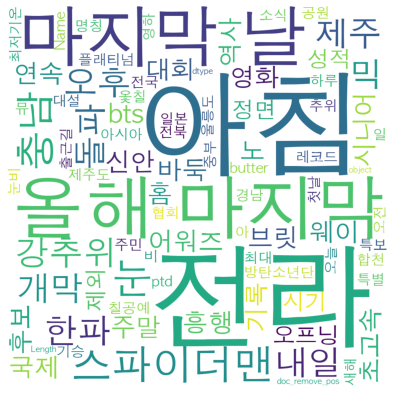

In [801]:
from wordcloud import WordCloud
# 위와 다르게 wordcloud 안에서는 stopword가 있어서 약간의 차이가 있음
wv = WordCloud(font_path='/System/Library/Fonts/Supplemental/AppleGothic.ttf',
                 background_color='white', max_words=100, max_font_size=300,
                 width=1000, height=1000)
wv.generate(str(new_news_df['doc_remove_pos']))
plt.imshow(wv)
plt.axis("off")
plt.show()

In [813]:
from nltk.probability import FreqDist
# parsing_df = load_pickle(os.path.join(rootpath.detect(), *["data", "rec", "parsing_data_df.pickle"]))

word_split = []
for i in range(new_news_df.shape[0]):
    for j in new_news_df.iloc[i]['tagged_doc']:
        word_split.append(j)

# 사전 업데이트가 조금 필요한 듯 ㅠㅠ
fd_names = FreqDist(word_split)
# fd_names.plot(50)
fd_names.most_common(100)

[('후보/NNG', 2651),
 ('말/NNG', 1225),
 ('국민/NNG', 1178),
 ('대표/NNG', 967),
 ('코로나/NNP', 897),
 ('사람/NNG', 870),
 ('힘/NNG', 829),
 ('정부/NNG', 805),
 ('대통령/NNG', 684),
 ('윤/NNG', 673),
 ('윤석열/NNP', 672),
 ('대선/NNG', 640),
 ('서울/NNP', 635),
 ('공개/NNG', 610),
 ('상황/NNG', 562),
 ('관련/NNG', 558),
 ('김/NNP', 552),
 ('조사/NNG', 548),
 ('이재명/NNP', 545),
 ('이번/NNG', 539),
 ('오미크론/NNG', 531),
 ('민주당/NNP', 516),
 ('생각/NNG', 507),
 ('방송/NNG', 506),
 ('경찰/NNG', 497),
 ('일/NNG', 484),
 ('접종/NNG', 483),
 ('문제/NNG', 477),
 ('선대위/NNP', 461),
 ('자신/NNG', 453),
 ('시간/NNG', 425),
 ('모습/NNG', 425),
 ('사면/NNG', 421),
 ('올해/NNG', 420),
 ('내년/NNG', 416),
 ('시작/NNG', 416),
 ('입장/NNG', 410),
 ('백신/NNG', 403),
 ('의혹/NNG', 399),
 ('미국/NNP', 389),
 ('확진자/NNP', 388),
 ('사진/NNG', 387),
 ('확인/NNG', 385),
 ('영화/NNG', 384),
 ('가능/NNG', 381),
 ('주장/NNG', 378),
 ('의원/NNG', 375),
 ('결과/NNG', 366),
 ('이상/NNG', 362),
 ('사과/NNG', 350),
 ('최근/NNG', 347),
 ('지역/NNG', 347),
 ('수사/NNG', 347),
 ('혐의/NNG', 343),
 ('대상/NNG', 340),
 ('

In [814]:
tokens = sorted(fd_names.items(), key = lambda x: x[1], reverse = False) 
tokens 
# for tokens in new_news_df['doc_remove_pos'][:2]:
#     for token in token

[('조훈현/NNP', 1),
 ('유창혁/NNP', 1),
 ('대덕/NNP', 1),
 ('시험장/NNG', 1),
 ('인터내셔널/NNG', 1),
 ('예매/NNG', 1),
 ('인피니티/NNP', 1),
 ('ptd/SL', 1),
 ('그룹/NNP', 1),
 ('cd/SL', 1),
 ('페이크/NNP', 1),
 ('군민/NNG', 1),
 ('청원서/NNG', 1),
 ('새천년/NNP', 1),
 ('칠기/NNG', 1),
 ('와일드/NNP', 1),
 ('국회의사당/NNP', 1),
 ('이창무/NNP', 1),
 ('유체/NNG', 1),
 ('이탈자/NNG', 1),
 ('지탱/NNG', 1),
 ('정상진/NNP', 1),
 ('정윤철/NNP', 1),
 ('허브/NNG', 1),
 ('아난다/NNG', 1),
 ('그중/NNG', 1),
 ('막심/NNG', 1),
 ('윤동진/NNP', 1),
 ('저작권자/NNG', 1),
 ('임차료/NNG', 1),
 ('볼보/NNP', 1),
 ('호랑이해/NNG', 1),
 ('산신도/NNP', 1),
 ('재속/NNG', 1),
 ('배턴/NNG', 1),
 ('스파이/NNG', 1),
 ('프리퀄/NNP', 1),
 ('랄프/NNP', 1),
 ('파인즈/NNP', 1),
 ('딕킨슨/NNP', 1),
 ('리스/NNP', 1),
 ('이판/NNP', 1),
 ('젬마/NNP', 1),
 ('아터튼/NNP', 1),
 ('구드/NNG', 1),
 ('해리/NNG', 1),
 ('옥스포드/NNP', 1),
 ('콘래드/NNP', 1),
 ('탈바꿈/NNG', 1),
 ('평과/NNG', 1),
 ('성전환/NNG', 1),
 ('라나/NNP', 1),
 ('워쇼스키/NNP', 1),
 ('부제/NNG', 1),
 ('한번/NNG', 1),
 ('키아누/NNP', 1),
 ('리브스/NNP', 1),
 ('트리니티/NNP', 1),
 ('모스/NNG', 1),
 ('모피/NNG', 1)